In [ ]:
## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

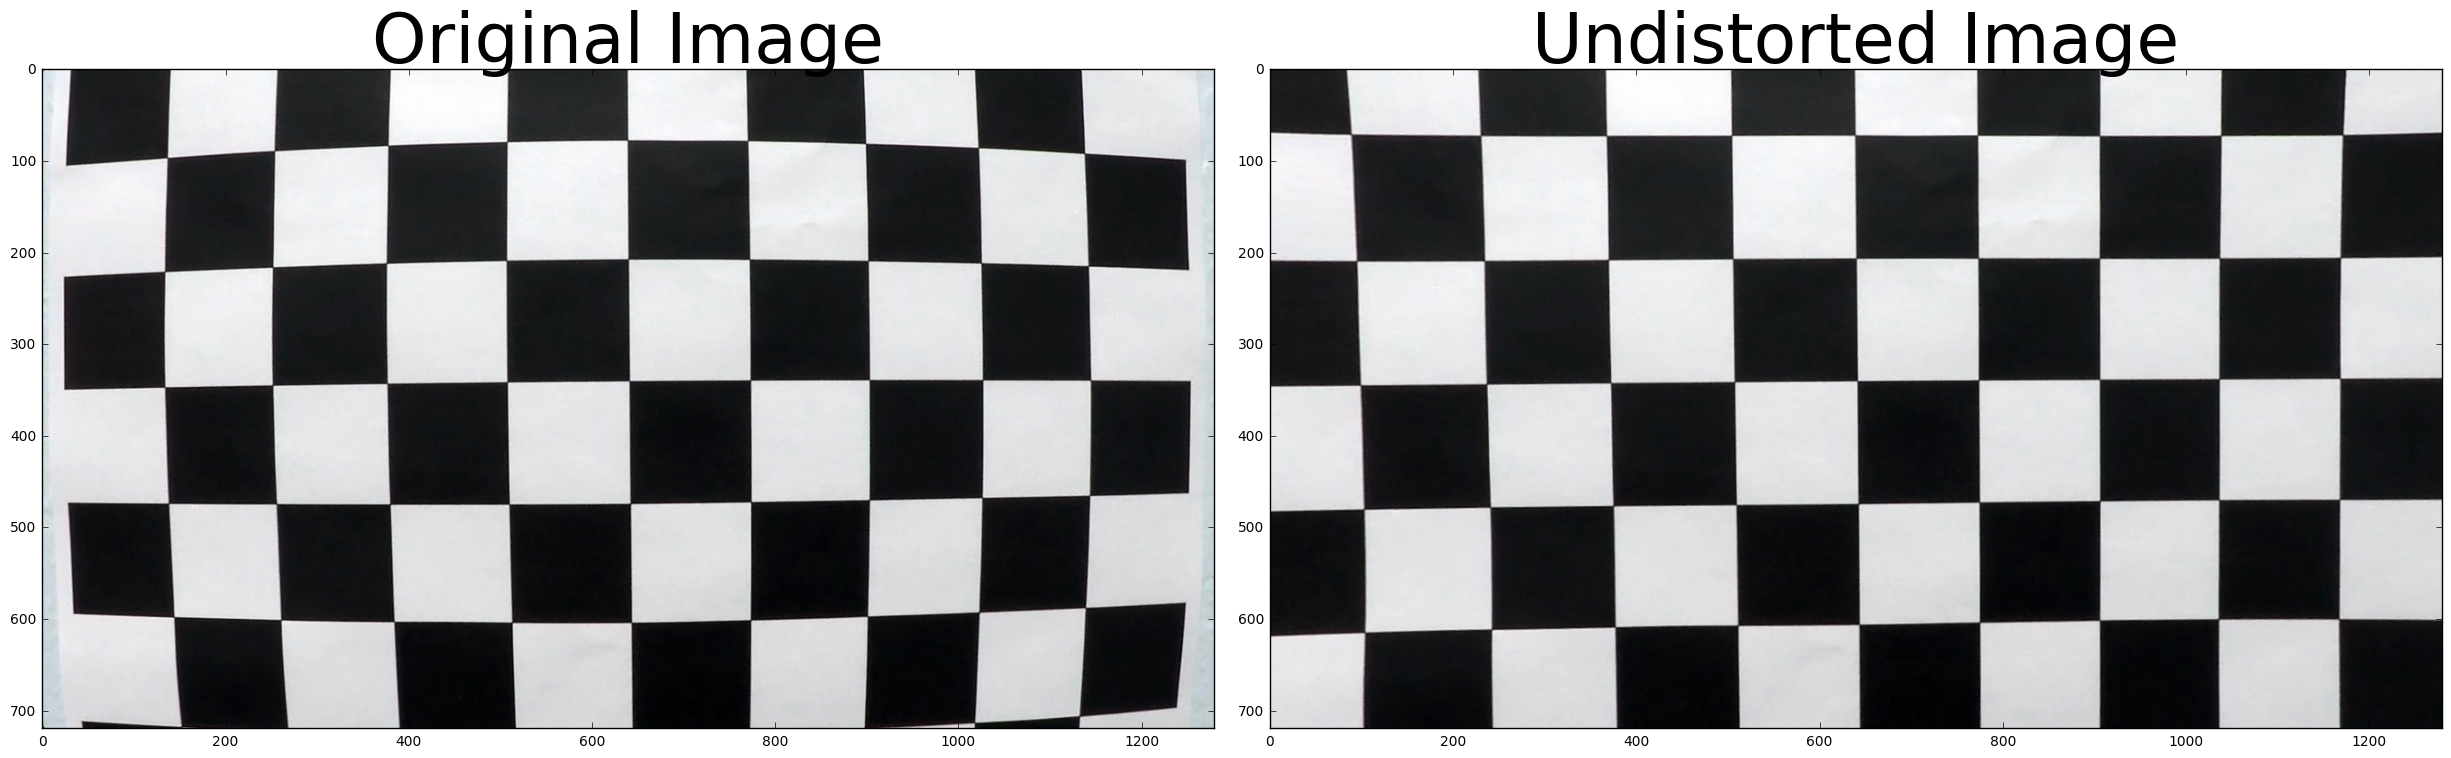

In [107]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import time
import matplotlib.image as mpmg


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

ksize = 3

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        

def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints, gray.shape[::-1],None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist
        

img = cv2.imread('./camera_cal/calibration1.jpg')

undistorted = cal_undistort(img, objpoints, imgpoints)
        
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
        #plt.imshow(img)
time.sleep(1)


#cv2.destro#yAllWindows()

In [108]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(0,255)):

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobelx = np.absolute(sobelx)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # 5) Create a mask of 1's where the scaled gradient magnitude
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)

    # 3) Calculate the magnitude
    sobelsqrtx = np.sqrt(np.square(sobelx))
    sobelsqrty = np.sqrt(np.square(sobely))
    sobelsqrtxy = np.absolute(np.sqrt(np.square(sobelx) + np.square(sobely) ))

    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobelsqrtxy/np.max(sobelsqrtxy))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):

    # Apply the following steps to img
    # 1) Convert to grayscale

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    arc_tan = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(arc_tan)
    binary_output[(arc_tan >= thresh[0]) & (arc_tan <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output## And so on and so forth...


 
img = mpmg.imread('./test_images/straight_lines1.jpg')

img = cal_undistort(img, objpoints, imgpoints)

# Threshold x gradient


sxbinary = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))

print (sxbinary)

gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(20, 100))
dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0, np.pi/2))
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
#print (combined)


[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


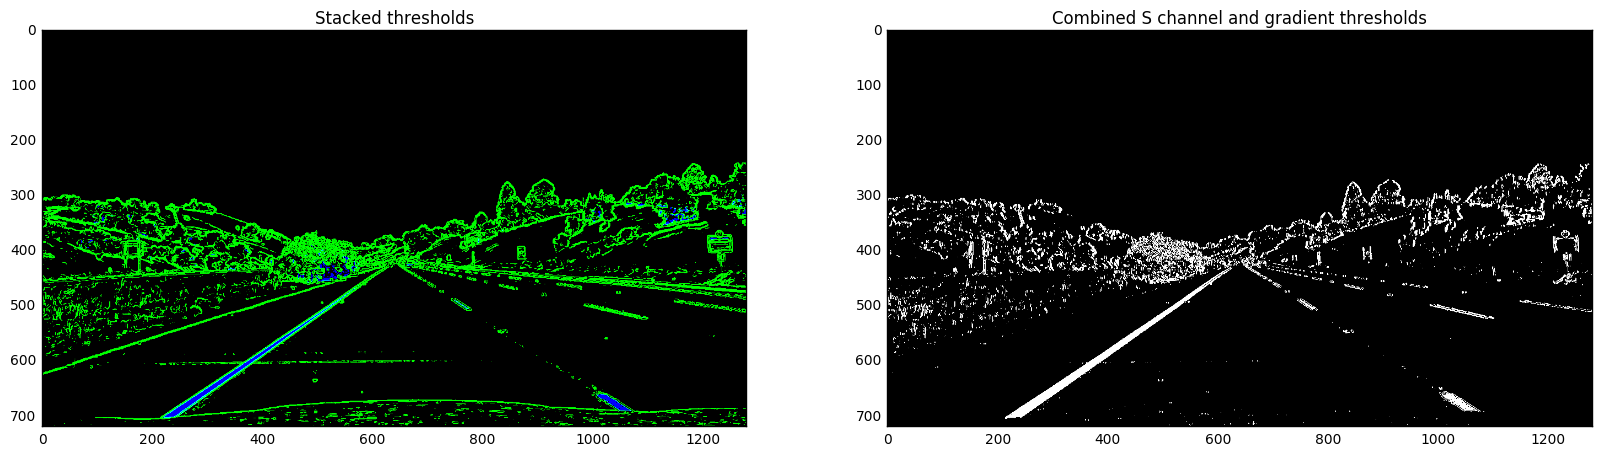

In [109]:
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
color_binary = np.dstack(( np.zeros_like(combined), combined, s_binary))
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary, cmap='gray')

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')
plt.show()

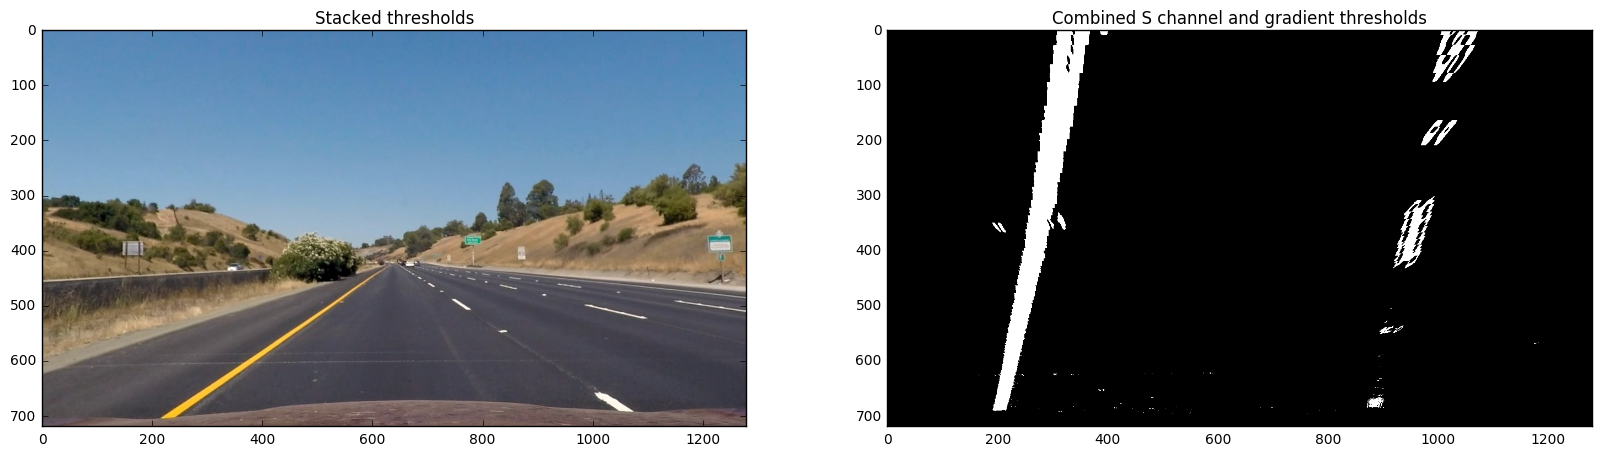

In [110]:
top_right_src = [680, 463]
top_left_src = [550, 463]
bottom_right_src = [1060, 680]
bottom_left_src = [245, 680]

top_right_dest = [900, 0]
top_left_dest = [190, 0]
bottom_right_dest = [900, 680]
bottom_left_dest = [190, 680]
# src coordinates
src = np.float32([
    top_right_src, # top right
    bottom_right_src, # bottom right
    bottom_left_src, # bottom left
    top_left_src # top left
])

# dest coordinates
dst = np.float32([
    top_right_dest, # top right
    bottom_right_dest, # bottom right
    bottom_left_dest, # bottom left
    top_left_dest # top left
])



M = cv2.getPerspectiveTransform(src, dst)



image_size = (img.shape[1], img.shape[0])
binary_warped = cv2.warpPerspective(combined_binary, M, image_size, flags=cv2.INTER_LINEAR) 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(img, cmap='gray')

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(binary_warped, cmap='gray')
plt.show()
       

In [111]:
##### Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
print (leftx_current,rightx_current)


# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

252 947


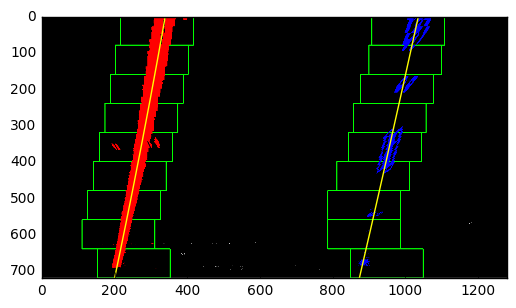

In [112]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


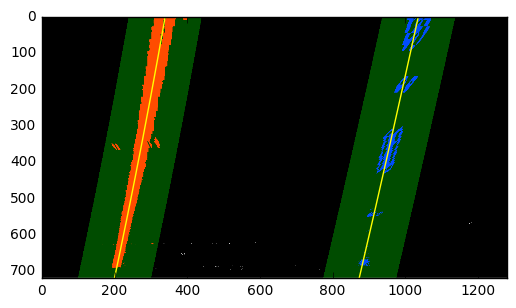

In [113]:
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

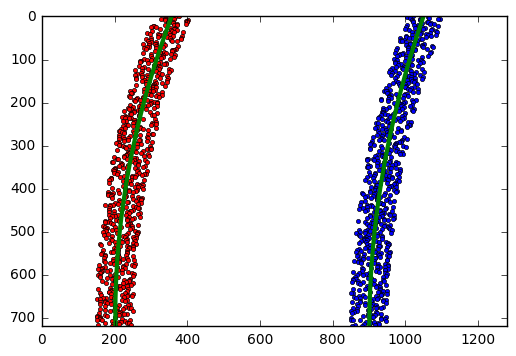

In [114]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images
plt.show()

In [115]:
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

1554.45265833 1768.57328222


In [116]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

510.364880769 m 580.87884063 m


[[[  3.56901303e+02   0.00000000e+00]
  [  3.56455211e+02   1.00000000e+00]
  [  3.56009763e+02   2.00000000e+00]
  ..., 
  [  1.04946298e+03   2.00000000e+00]
  [  1.04987289e+03   1.00000000e+00]
  [  1.05028336e+03   0.00000000e+00]]]


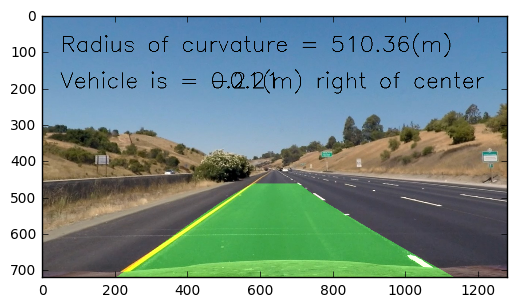

In [127]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))
print (pts)

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
center_lane = (leftx_current + rightx_current)/2
offset = 640 - center_lane
xm_per_pix = 3.7/700
left_of_center = offset*xm_per_pix

text = 'Radius of curvature = '+str(round(left_curverad,2)) + '(m)'
offset_text = ''
if round(left_of_center,2) > 0:
    offset_text = 'Vehicle is = ' + str(round(left_of_center,2)) + '(m) left of center'
else:
    offset_text = 'Vehicle is = ' + str(abs(round(left_of_center,2))) + '(m) right of center'

  


# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, M, (img.shape[1], img.shape[0]), flags=cv2.WARP_INVERSE_MAP ) 
# Combine the result with the original image
result = cv2.addWeighted(img, 1, newwarp, 0.4, 0)
result = cv2.putText(result,text, (50,100), cv2.FONT_HERSHEY_SIMPLEX,2 , 0,2)
result = cv2.putText(result,offset_text, (50,200), cv2.FONT_HERSHEY_SIMPLEX,2 , 0,2)


plt.imshow(result)
plt.show()

In [130]:
 def process_image(image):
    img = image

    img = cal_undistort(img, objpoints, imgpoints)

    # Threshold x gradient


    sxbinary = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))


    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(20, 100))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0, np.pi/2))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    #print (combined)


    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    color_binary = np.dstack(( np.zeros_like(combined), combined, s_binary))
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    top_right_src = [680, 463]
    top_left_src = [550, 463]
    bottom_right_src = [1060, 680]
    bottom_left_src = [245, 680]

    top_right_dest = [900, 0]
    top_left_dest = [190, 0]
    bottom_right_dest = [900, 680]
    bottom_left_dest = [190, 680]
# src coordinates
    # src coordinates
    src = np.float32([
        top_right_src, # top right
        bottom_right_src, # bottom right
        bottom_left_src, # bottom left
        top_left_src # top left
    ])

    # dest coordinates
    dst = np.float32([
        top_right_dest, # top right
        bottom_right_dest, # bottom right
        bottom_left_dest, # bottom left
        top_left_dest # top left
    ])



    M = cv2.getPerspectiveTransform(src, dst)



    image_size = (img.shape[1], img.shape[0])
    binary_warped = cv2.warpPerspective(combined_binary, M, image_size, flags=cv2.INTER_LINEAR) 

        # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    center_lane = (leftx_current + rightx_current)/2
    offset = 640 - center_lane
    xm_per_pix = 3.7/700
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)


    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)


    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                  for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Plot up the fake data
    mark_size = 3


    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])


    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters

    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    left_of_center = offset*xm_per_pix

    text = 'Radius of curvature = '+str(round(left_curverad,2)) + '(m)'
    offset_text = ''
    if round(left_of_center,2) > 0:
        offset_text = 'Vehicle is = ' + str(round(left_of_center,2)) + '(m) right of center'
    else:
        offset_text = 'Vehicle is = ' + str(abs(round(left_of_center,2))) + '(m) left of center'




    print('left')
    print ('left_of_center',left_of_center)
      

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))




    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M, (img.shape[1], img.shape[0]), flags=cv2.WARP_INVERSE_MAP ) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.4, 0)
    result = cv2.putText(result,text, (50,100), cv2.FONT_HERSHEY_SIMPLEX,2 , 0,2)
    result = cv2.putText(result,offset_text, (50,200), cv2.FONT_HERSHEY_SIMPLEX,2 , 0,2)

    
    return result


In [131]:

from moviepy.editor import VideoFileClip
from IPython.display import HTML
challenge_output = 'new1.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) 

%time white_clip.write_videofile(challenge_output, audio=False)



left
left_of_center 0.037
[MoviePy] >>>> Building video new1.mp4
[MoviePy] Writing video new1.mp4


  0%|          | 1/1261 [00:01<35:00,  1.67s/it]

left
left_of_center 0.037


  0%|          | 2/1261 [00:03<35:06,  1.67s/it]

left
left_of_center 0.0528571428571


  0%|          | 3/1261 [00:04<34:00,  1.62s/it]

left
left_of_center 0.0607857142857


  0%|          | 4/1261 [00:06<34:28,  1.65s/it]

left
left_of_center 0.0634285714286


  0%|          | 5/1261 [00:08<33:57,  1.62s/it]

left
left_of_center 0.0766428571429


  0%|          | 6/1261 [00:09<33:30,  1.60s/it]

left
left_of_center 0.0766428571429


  1%|          | 7/1261 [00:11<33:13,  1.59s/it]

left
left_of_center 0.0607857142857


  1%|          | 8/1261 [00:12<33:29,  1.60s/it]

left
left_of_center 0.0766428571429


  1%|          | 9/1261 [00:14<33:03,  1.58s/it]

left
left_of_center 0.0343571428571


  1%|          | 10/1261 [00:15<32:57,  1.58s/it]

left
left_of_center 0.0264285714286


  1%|          | 11/1261 [00:17<32:56,  1.58s/it]

left
left_of_center 0.0422857142857


  1%|          | 12/1261 [00:19<33:24,  1.61s/it]

left
left_of_center 0.0317142857143


  1%|          | 13/1261 [00:20<33:21,  1.60s/it]

left
left_of_center 0.0449285714286


  1%|          | 14/1261 [00:22<33:19,  1.60s/it]

left
left_of_center 0.0607857142857


  1%|          | 15/1261 [00:24<33:55,  1.63s/it]

left
left_of_center 0.0977857142857


  1%|▏         | 16/1261 [00:25<33:45,  1.63s/it]

left
left_of_center 0.100428571429


  1%|▏         | 17/1261 [00:27<33:21,  1.61s/it]

left
left_of_center 0.137428571429


  1%|▏         | 18/1261 [00:28<32:59,  1.59s/it]

left
left_of_center 0.105714285714


  2%|▏         | 19/1261 [00:30<32:57,  1.59s/it]

left
left_of_center 0.148


  2%|▏         | 20/1261 [00:32<33:20,  1.61s/it]

left
left_of_center 0.148


  2%|▏         | 21/1261 [00:33<33:20,  1.61s/it]

left
left_of_center 0.134785714286


  2%|▏         | 22/1261 [00:35<33:12,  1.61s/it]

left
left_of_center 0.0845714285714


  2%|▏         | 23/1261 [00:37<33:56,  1.65s/it]

left
left_of_center 0.0898571428571


  2%|▏         | 24/1261 [00:38<33:53,  1.64s/it]

left
left_of_center 0.108357142857


  2%|▏         | 25/1261 [00:40<33:58,  1.65s/it]

left
left_of_center 0.124214285714


  2%|▏         | 26/1261 [00:42<33:55,  1.65s/it]

left
left_of_center 0.113642857143


  2%|▏         | 27/1261 [00:43<34:17,  1.67s/it]

left
left_of_center 0.118928571429


  2%|▏         | 28/1261 [00:45<34:12,  1.66s/it]

left
left_of_center 0.1295


  2%|▏         | 29/1261 [00:47<34:02,  1.66s/it]

left
left_of_center 0.145357142857


  2%|▏         | 30/1261 [00:48<33:56,  1.65s/it]

left
left_of_center 0.169142857143


  2%|▏         | 31/1261 [00:50<33:44,  1.65s/it]

left
left_of_center 0.150642857143


  3%|▎         | 32/1261 [00:51<33:22,  1.63s/it]

left
left_of_center 0.155928571429


  3%|▎         | 33/1261 [00:53<33:18,  1.63s/it]

left
left_of_center 0.148


  3%|▎         | 34/1261 [00:55<33:29,  1.64s/it]

left
left_of_center 0.142714285714


  3%|▎         | 35/1261 [00:56<33:48,  1.65s/it]

left
left_of_center 0.0977857142857


  3%|▎         | 36/1261 [00:59<37:19,  1.83s/it]

left
left_of_center 0.0951428571429


  3%|▎         | 37/1261 [01:01<38:14,  1.87s/it]

left
left_of_center 0.0977857142857


  3%|▎         | 38/1261 [01:02<37:29,  1.84s/it]

left
left_of_center 0.103071428571


  3%|▎         | 39/1261 [01:04<36:02,  1.77s/it]

left
left_of_center 0.116285714286


  3%|▎         | 40/1261 [01:06<35:17,  1.73s/it]

left
left_of_center 0.121571428571


  3%|▎         | 41/1261 [01:07<34:55,  1.72s/it]

left
left_of_center 0.134785714286


  3%|▎         | 42/1261 [01:09<34:21,  1.69s/it]

left
left_of_center 0.137428571429


  3%|▎         | 43/1261 [01:11<34:44,  1.71s/it]

left
left_of_center 0.132142857143


  3%|▎         | 44/1261 [01:12<34:37,  1.71s/it]

left
left_of_center 0.134785714286


  4%|▎         | 45/1261 [01:14<35:06,  1.73s/it]

left
left_of_center 0.126857142857


  4%|▎         | 46/1261 [01:16<34:55,  1.72s/it]

left
left_of_center 0.134785714286


  4%|▎         | 47/1261 [01:18<35:24,  1.75s/it]

left
left_of_center 0.0872142857143


  4%|▍         | 48/1261 [01:20<35:56,  1.78s/it]

left
left_of_center 0.0898571428571


  4%|▍         | 49/1261 [01:21<36:20,  1.80s/it]

left
left_of_center 0.0977857142857


  4%|▍         | 50/1261 [01:23<35:50,  1.78s/it]

left
left_of_center 0.100428571429


  4%|▍         | 51/1261 [01:25<35:29,  1.76s/it]

left
left_of_center 0.118928571429


  4%|▍         | 52/1261 [01:27<35:57,  1.78s/it]

left
left_of_center 0.124214285714


  4%|▍         | 53/1261 [01:28<35:08,  1.75s/it]

left
left_of_center 0.1295


  4%|▍         | 54/1261 [01:30<34:40,  1.72s/it]

left
left_of_center 0.158571428571


  4%|▍         | 55/1261 [01:32<35:03,  1.74s/it]

left
left_of_center 0.150642857143


  4%|▍         | 56/1261 [01:34<35:04,  1.75s/it]

left
left_of_center 0.185


  5%|▍         | 57/1261 [01:35<35:33,  1.77s/it]

left
left_of_center 0.179714285714


  5%|▍         | 58/1261 [01:37<36:12,  1.81s/it]

left
left_of_center 0.192928571429


  5%|▍         | 59/1261 [01:39<36:38,  1.83s/it]

left
left_of_center 0.187642857143


  5%|▍         | 60/1261 [01:41<36:43,  1.83s/it]

left
left_of_center 0.200857142857


  5%|▍         | 61/1261 [01:43<36:56,  1.85s/it]

left
left_of_center 0.177071428571


  5%|▍         | 62/1261 [01:45<36:24,  1.82s/it]

left
left_of_center 0.179714285714


  5%|▍         | 63/1261 [01:46<35:48,  1.79s/it]

left
left_of_center 0.179714285714


  5%|▌         | 64/1261 [01:48<35:35,  1.78s/it]

left
left_of_center 0.179714285714


  5%|▌         | 65/1261 [01:50<35:45,  1.79s/it]

left
left_of_center 0.208785714286


  5%|▌         | 66/1261 [01:52<35:54,  1.80s/it]

left
left_of_center 0.208785714286


  5%|▌         | 67/1261 [01:53<35:17,  1.77s/it]

left
left_of_center 0.216714285714


  5%|▌         | 68/1261 [01:55<34:56,  1.76s/it]

left
left_of_center 0.227285714286


  5%|▌         | 69/1261 [01:57<35:15,  1.77s/it]

left
left_of_center 0.235214285714


  6%|▌         | 70/1261 [01:59<35:31,  1.79s/it]

left
left_of_center 0.235214285714


  6%|▌         | 71/1261 [02:01<35:46,  1.80s/it]

left
left_of_center 0.2405


  6%|▌         | 72/1261 [02:02<35:41,  1.80s/it]

left
left_of_center 0.200857142857


  6%|▌         | 73/1261 [02:04<35:20,  1.79s/it]

left
left_of_center 0.208785714286


  6%|▌         | 74/1261 [02:06<35:31,  1.80s/it]

left
left_of_center 0.224642857143


  6%|▌         | 75/1261 [02:08<35:29,  1.80s/it]

left
left_of_center 0.222


  6%|▌         | 76/1261 [02:10<35:14,  1.78s/it]

left
left_of_center 0.237857142857


  6%|▌         | 77/1261 [02:11<34:47,  1.76s/it]

left
left_of_center 0.245785714286


  6%|▌         | 78/1261 [02:13<34:50,  1.77s/it]

left
left_of_center 0.253714285714


  6%|▋         | 79/1261 [02:15<34:49,  1.77s/it]

left
left_of_center 0.282785714286


  6%|▋         | 80/1261 [02:17<34:58,  1.78s/it]

left
left_of_center 0.272214285714


  6%|▋         | 81/1261 [02:18<34:58,  1.78s/it]

left
left_of_center 0.303928571429


  7%|▋         | 82/1261 [02:20<34:36,  1.76s/it]

left
left_of_center 0.251071428571


  7%|▋         | 83/1261 [02:22<34:56,  1.78s/it]

left
left_of_center 0.274857142857


  7%|▋         | 84/1261 [02:24<34:28,  1.76s/it]

left
left_of_center 0.269571428571


  7%|▋         | 85/1261 [02:25<34:28,  1.76s/it]

left
left_of_center 0.253714285714


  7%|▋         | 86/1261 [02:27<34:27,  1.76s/it]

left
left_of_center 0.224642857143


  7%|▋         | 87/1261 [02:29<34:23,  1.76s/it]

left
left_of_center 0.232571428571


  7%|▋         | 88/1261 [02:31<34:34,  1.77s/it]

left
left_of_center 0.2405


  7%|▋         | 89/1261 [02:32<34:18,  1.76s/it]

left
left_of_center 0.237857142857


  7%|▋         | 90/1261 [02:34<34:32,  1.77s/it]

left
left_of_center 0.248428571429


  7%|▋         | 91/1261 [02:36<34:28,  1.77s/it]

left
left_of_center 0.243142857143


  7%|▋         | 92/1261 [02:38<35:11,  1.81s/it]

left
left_of_center 0.251071428571


  7%|▋         | 93/1261 [02:40<35:00,  1.80s/it]

left
left_of_center 0.259


  7%|▋         | 94/1261 [02:41<34:41,  1.78s/it]

left
left_of_center 0.245785714286


  8%|▊         | 95/1261 [02:43<34:23,  1.77s/it]

left
left_of_center 0.245785714286


  8%|▊         | 96/1261 [02:45<34:16,  1.76s/it]

left
left_of_center 0.245785714286


  8%|▊         | 97/1261 [02:47<33:59,  1.75s/it]

left
left_of_center 0.190285714286


  8%|▊         | 98/1261 [02:48<33:57,  1.75s/it]

left
left_of_center 0.190285714286


  8%|▊         | 99/1261 [02:50<33:47,  1.74s/it]

left
left_of_center 0.206142857143


  8%|▊         | 100/1261 [02:52<33:36,  1.74s/it]

left
left_of_center 0.214071428571


  8%|▊         | 101/1261 [02:54<33:55,  1.76s/it]

left
left_of_center 0.219357142857


  8%|▊         | 102/1261 [02:55<33:44,  1.75s/it]

left
left_of_center 0.224642857143


  8%|▊         | 103/1261 [02:57<33:44,  1.75s/it]

left
left_of_center 0.224642857143


  8%|▊         | 104/1261 [02:59<34:14,  1.78s/it]

left
left_of_center 0.224642857143


  8%|▊         | 105/1261 [03:01<34:08,  1.77s/it]

left
left_of_center 0.243142857143


  8%|▊         | 106/1261 [03:03<34:09,  1.77s/it]

left
left_of_center 0.248428571429


  8%|▊         | 107/1261 [03:04<33:51,  1.76s/it]

left
left_of_center 0.264285714286


  9%|▊         | 108/1261 [03:06<34:07,  1.78s/it]

left
left_of_center 0.179714285714


  9%|▊         | 109/1261 [03:08<33:36,  1.75s/it]

left
left_of_center 0.177071428571


  9%|▊         | 110/1261 [03:09<33:21,  1.74s/it]

left
left_of_center 0.134785714286


  9%|▉         | 111/1261 [03:11<33:30,  1.75s/it]

left
left_of_center 0.1295


  9%|▉         | 112/1261 [03:13<33:39,  1.76s/it]

left
left_of_center 0.132142857143


  9%|▉         | 113/1261 [03:15<33:34,  1.75s/it]

left
left_of_center 0.142714285714


  9%|▉         | 114/1261 [03:17<33:58,  1.78s/it]

left
left_of_center 0.142714285714


  9%|▉         | 115/1261 [03:18<34:03,  1.78s/it]

left
left_of_center 0.148


  9%|▉         | 116/1261 [03:20<33:25,  1.75s/it]

left
left_of_center 0.153285714286


  9%|▉         | 117/1261 [03:22<33:54,  1.78s/it]

left
left_of_center 0.177071428571


  9%|▉         | 118/1261 [03:24<34:04,  1.79s/it]

left
left_of_center 0.182357142857


  9%|▉         | 119/1261 [03:25<33:51,  1.78s/it]

left
left_of_center 0.158571428571


 10%|▉         | 120/1261 [03:27<33:25,  1.76s/it]

left
left_of_center 0.153285714286


 10%|▉         | 121/1261 [03:29<33:07,  1.74s/it]

left
left_of_center 0.137428571429


 10%|▉         | 122/1261 [03:31<33:31,  1.77s/it]

left
left_of_center 0.132142857143


 10%|▉         | 123/1261 [03:33<34:04,  1.80s/it]

left
left_of_center 0.0925


 10%|▉         | 124/1261 [03:34<33:58,  1.79s/it]

left
left_of_center 0.124214285714


 10%|▉         | 125/1261 [03:36<33:26,  1.77s/it]

left
left_of_center 0.121571428571


 10%|▉         | 126/1261 [03:38<34:16,  1.81s/it]

left
left_of_center 0.1295


 10%|█         | 127/1261 [03:40<33:58,  1.80s/it]

left
left_of_center 0.132142857143


 10%|█         | 128/1261 [03:42<34:24,  1.82s/it]

left
left_of_center 0.118928571429


 10%|█         | 129/1261 [03:44<35:01,  1.86s/it]

left
left_of_center 0.121571428571


 10%|█         | 130/1261 [03:45<34:33,  1.83s/it]

left
left_of_center 0.132142857143


 10%|█         | 131/1261 [03:47<34:03,  1.81s/it]

left
left_of_center 0.134785714286


 10%|█         | 132/1261 [03:49<34:12,  1.82s/it]

left
left_of_center 0.140071428571


 11%|█         | 133/1261 [03:51<34:31,  1.84s/it]

left
left_of_center 0.134785714286


 11%|█         | 134/1261 [03:53<34:16,  1.83s/it]

left
left_of_center 0.132142857143


 11%|█         | 135/1261 [03:54<34:09,  1.82s/it]

left
left_of_center 0.0845714285714


 11%|█         | 136/1261 [03:56<34:10,  1.82s/it]

left
left_of_center 0.0713571428571


 11%|█         | 137/1261 [03:58<34:24,  1.84s/it]

left
left_of_center 0.074


 11%|█         | 138/1261 [04:00<33:57,  1.81s/it]

left
left_of_center 0.074


 11%|█         | 139/1261 [04:02<33:32,  1.79s/it]

left
left_of_center 0.0925


 11%|█         | 140/1261 [04:03<33:45,  1.81s/it]

left
left_of_center 0.0951428571429


 11%|█         | 141/1261 [04:05<33:51,  1.81s/it]

left
left_of_center 0.0898571428571


 11%|█▏        | 142/1261 [04:07<33:57,  1.82s/it]

left
left_of_center 0.124214285714


 11%|█▏        | 143/1261 [04:09<33:32,  1.80s/it]

left
left_of_center 0.124214285714


 11%|█▏        | 144/1261 [04:11<33:13,  1.78s/it]

left
left_of_center 0.134785714286


 11%|█▏        | 145/1261 [04:12<33:28,  1.80s/it]

left
left_of_center 0.134785714286


 12%|█▏        | 146/1261 [04:14<33:26,  1.80s/it]

left
left_of_center 0.1295


 12%|█▏        | 147/1261 [04:16<33:02,  1.78s/it]

left
left_of_center 0.126857142857


 12%|█▏        | 148/1261 [04:18<33:17,  1.79s/it]

left
left_of_center 0.103071428571


 12%|█▏        | 149/1261 [04:20<33:25,  1.80s/it]

left
left_of_center 0.0925


 12%|█▏        | 150/1261 [04:21<33:17,  1.80s/it]

left
left_of_center 0.0951428571429


 12%|█▏        | 151/1261 [04:23<33:03,  1.79s/it]

left
left_of_center 0.100428571429


 12%|█▏        | 152/1261 [04:25<32:33,  1.76s/it]

left
left_of_center 0.113642857143


 12%|█▏        | 153/1261 [04:27<32:16,  1.75s/it]

left
left_of_center 0.134785714286


 12%|█▏        | 154/1261 [04:28<32:51,  1.78s/it]

left
left_of_center 0.137428571429


 12%|█▏        | 155/1261 [04:30<32:35,  1.77s/it]

left
left_of_center 0.134785714286


 12%|█▏        | 156/1261 [04:32<32:27,  1.76s/it]

left
left_of_center 0.145357142857


 12%|█▏        | 157/1261 [04:34<32:30,  1.77s/it]

left
left_of_center 0.145357142857


 13%|█▎        | 158/1261 [04:35<32:01,  1.74s/it]

left
left_of_center 0.155928571429


 13%|█▎        | 159/1261 [04:37<31:51,  1.73s/it]

left
left_of_center 0.158571428571


 13%|█▎        | 160/1261 [04:39<31:41,  1.73s/it]

left
left_of_center 0.108357142857


 13%|█▎        | 161/1261 [04:41<31:50,  1.74s/it]

left
left_of_center 0.124214285714


 13%|█▎        | 162/1261 [04:42<32:13,  1.76s/it]

left
left_of_center 0.124214285714


 13%|█▎        | 163/1261 [04:44<32:13,  1.76s/it]

left
left_of_center 0.124214285714


 13%|█▎        | 164/1261 [04:46<32:23,  1.77s/it]

left
left_of_center 0.171785714286


 13%|█▎        | 165/1261 [04:48<32:31,  1.78s/it]

left
left_of_center 0.185


 13%|█▎        | 166/1261 [04:50<32:21,  1.77s/it]

left
left_of_center 0.195571428571


 13%|█▎        | 167/1261 [04:51<32:27,  1.78s/it]

left
left_of_center 0.200857142857


 13%|█▎        | 168/1261 [04:53<32:20,  1.78s/it]

left
left_of_center 0.2035


 13%|█▎        | 169/1261 [04:55<32:23,  1.78s/it]

left
left_of_center 0.214071428571


 13%|█▎        | 170/1261 [04:57<32:33,  1.79s/it]

left
left_of_center 0.200857142857


 14%|█▎        | 171/1261 [04:59<32:52,  1.81s/it]

left
left_of_center 0.216714285714


 14%|█▎        | 172/1261 [05:00<32:23,  1.78s/it]

left
left_of_center 0.216714285714


 14%|█▎        | 173/1261 [05:02<32:11,  1.77s/it]

left
left_of_center 0.182357142857


 14%|█▍        | 174/1261 [05:04<32:33,  1.80s/it]

left
left_of_center 0.200857142857


 14%|█▍        | 175/1261 [05:06<32:14,  1.78s/it]

left
left_of_center 0.208785714286


 14%|█▍        | 176/1261 [05:07<31:47,  1.76s/it]

left
left_of_center 0.224642857143


 14%|█▍        | 177/1261 [05:09<31:55,  1.77s/it]

left
left_of_center 0.232571428571


 14%|█▍        | 178/1261 [05:11<31:55,  1.77s/it]

left
left_of_center 0.219357142857


 14%|█▍        | 179/1261 [05:13<32:12,  1.79s/it]

left
left_of_center 0.2405


 14%|█▍        | 180/1261 [05:15<32:13,  1.79s/it]

left
left_of_center 0.248428571429


 14%|█▍        | 181/1261 [05:16<32:55,  1.83s/it]

left
left_of_center 0.224642857143


 14%|█▍        | 182/1261 [05:18<32:23,  1.80s/it]

left
left_of_center 0.198214285714


 15%|█▍        | 183/1261 [05:20<32:11,  1.79s/it]

left
left_of_center 0.206142857143


 15%|█▍        | 184/1261 [05:22<32:03,  1.79s/it]

left
left_of_center 0.200857142857


 15%|█▍        | 185/1261 [05:23<31:34,  1.76s/it]

left
left_of_center 0.132142857143


 15%|█▍        | 186/1261 [05:25<31:35,  1.76s/it]

left
left_of_center 0.140071428571


 15%|█▍        | 187/1261 [05:27<31:37,  1.77s/it]

left
left_of_center 0.142714285714


 15%|█▍        | 188/1261 [05:29<31:29,  1.76s/it]

left
left_of_center 0.140071428571


 15%|█▍        | 189/1261 [05:30<31:07,  1.74s/it]

left
left_of_center 0.177071428571


 15%|█▌        | 190/1261 [05:32<30:51,  1.73s/it]

left
left_of_center 0.155928571429


 15%|█▌        | 191/1261 [05:34<30:52,  1.73s/it]

left
left_of_center 0.179714285714


 15%|█▌        | 192/1261 [05:36<30:57,  1.74s/it]

left
left_of_center 0.177071428571


 15%|█▌        | 193/1261 [05:37<31:03,  1.75s/it]

left
left_of_center 0.187642857143


 15%|█▌        | 194/1261 [05:39<31:07,  1.75s/it]

left
left_of_center 0.190285714286


 15%|█▌        | 195/1261 [05:41<31:14,  1.76s/it]

left
left_of_center 0.195571428571


 16%|█▌        | 196/1261 [05:43<31:36,  1.78s/it]

left
left_of_center 0.190285714286


 16%|█▌        | 197/1261 [05:44<31:21,  1.77s/it]

left
left_of_center 0.1295


 16%|█▌        | 198/1261 [05:46<31:15,  1.76s/it]

left
left_of_center 0.134785714286


 16%|█▌        | 199/1261 [05:48<31:19,  1.77s/it]

left
left_of_center 0.111


 16%|█▌        | 200/1261 [05:50<31:42,  1.79s/it]

left
left_of_center 0.150642857143


 16%|█▌        | 201/1261 [05:52<31:27,  1.78s/it]

left
left_of_center 0.1665


 16%|█▌        | 202/1261 [05:53<31:18,  1.77s/it]

left
left_of_center 0.179714285714


 16%|█▌        | 203/1261 [05:55<31:23,  1.78s/it]

left
left_of_center 0.211428571429


 16%|█▌        | 204/1261 [05:57<31:00,  1.76s/it]

left
left_of_center 0.208785714286


 16%|█▋        | 205/1261 [05:59<31:02,  1.76s/it]

left
left_of_center 0.222


 16%|█▋        | 206/1261 [06:00<30:43,  1.75s/it]

left
left_of_center 0.224642857143


 16%|█▋        | 207/1261 [06:02<30:59,  1.76s/it]

left
left_of_center 0.237857142857


 16%|█▋        | 208/1261 [06:04<30:38,  1.75s/it]

left
left_of_center 0.2405


 17%|█▋        | 209/1261 [06:06<31:00,  1.77s/it]

left
left_of_center 0.235214285714


 17%|█▋        | 210/1261 [06:07<30:57,  1.77s/it]

left
left_of_center 0.198214285714


 17%|█▋        | 211/1261 [06:09<30:44,  1.76s/it]

left
left_of_center 0.1665


 17%|█▋        | 212/1261 [06:11<30:31,  1.75s/it]

left
left_of_center 0.198214285714


 17%|█▋        | 213/1261 [06:13<30:58,  1.77s/it]

left
left_of_center 0.200857142857


 17%|█▋        | 214/1261 [06:15<31:20,  1.80s/it]

left
left_of_center 0.200857142857


 17%|█▋        | 215/1261 [06:16<31:18,  1.80s/it]

left
left_of_center 0.208785714286


 17%|█▋        | 216/1261 [06:18<30:59,  1.78s/it]

left
left_of_center 0.216714285714


 17%|█▋        | 217/1261 [06:20<31:17,  1.80s/it]

left
left_of_center 0.245785714286


 17%|█▋        | 218/1261 [06:22<31:34,  1.82s/it]

left
left_of_center 0.253714285714


 17%|█▋        | 219/1261 [06:24<31:01,  1.79s/it]

left
left_of_center 0.272214285714


 17%|█▋        | 220/1261 [06:25<30:35,  1.76s/it]

left
left_of_center 0.280142857143


 18%|█▊        | 221/1261 [06:27<30:42,  1.77s/it]

left
left_of_center 0.282785714286


 18%|█▊        | 222/1261 [06:29<30:20,  1.75s/it]

left
left_of_center 0.264285714286


 18%|█▊        | 223/1261 [06:31<30:25,  1.76s/it]

left
left_of_center 0.293357142857


 18%|█▊        | 224/1261 [06:32<30:28,  1.76s/it]

left
left_of_center 0.269571428571


 18%|█▊        | 225/1261 [06:34<30:25,  1.76s/it]

left
left_of_center 0.248428571429


 18%|█▊        | 226/1261 [06:36<30:25,  1.76s/it]

left
left_of_center 0.282785714286


 18%|█▊        | 227/1261 [06:38<30:24,  1.76s/it]

left
left_of_center 0.301285714286


 18%|█▊        | 228/1261 [06:39<30:15,  1.76s/it]

left
left_of_center 0.319785714286


 18%|█▊        | 229/1261 [06:41<29:57,  1.74s/it]

left
left_of_center 0.327714285714


 18%|█▊        | 230/1261 [06:43<29:56,  1.74s/it]

left
left_of_center 0.338285714286


 18%|█▊        | 231/1261 [06:45<30:40,  1.79s/it]

left
left_of_center 0.346214285714


 18%|█▊        | 232/1261 [06:46<30:54,  1.80s/it]

left
left_of_center 0.348857142857


 18%|█▊        | 233/1261 [06:48<30:27,  1.78s/it]

left
left_of_center 0.3515


 19%|█▊        | 234/1261 [06:50<30:04,  1.76s/it]

left
left_of_center 0.3145


 19%|█▊        | 235/1261 [06:52<30:16,  1.77s/it]

left
left_of_center 0.319785714286


 19%|█▊        | 236/1261 [06:54<30:17,  1.77s/it]

left
left_of_center 0.356785714286


 19%|█▉        | 237/1261 [06:55<29:41,  1.74s/it]

left
left_of_center 0.362071428571


 19%|█▉        | 238/1261 [06:57<29:29,  1.73s/it]

left
left_of_center 0.364714285714


 19%|█▉        | 239/1261 [06:59<29:39,  1.74s/it]

left
left_of_center 0.372642857143


 19%|█▉        | 240/1261 [07:00<29:46,  1.75s/it]

left
left_of_center 0.377928571429


 19%|█▉        | 241/1261 [07:02<30:09,  1.77s/it]

left
left_of_center 0.3885


 19%|█▉        | 242/1261 [07:04<29:54,  1.76s/it]

left
left_of_center 0.391142857143


 19%|█▉        | 243/1261 [07:06<30:08,  1.78s/it]

left
left_of_center 0.372642857143


 19%|█▉        | 244/1261 [07:08<29:52,  1.76s/it]

left
left_of_center 0.380571428571


 19%|█▉        | 245/1261 [07:09<29:50,  1.76s/it]

left
left_of_center 0.380571428571


 20%|█▉        | 246/1261 [07:11<30:25,  1.80s/it]

left
left_of_center 0.399071428571


 20%|█▉        | 247/1261 [07:13<30:45,  1.82s/it]

left
left_of_center 0.362071428571


 20%|█▉        | 248/1261 [07:15<30:18,  1.80s/it]

left
left_of_center 0.343571428571


 20%|█▉        | 249/1261 [07:17<30:22,  1.80s/it]

left
left_of_center 0.37


 20%|█▉        | 250/1261 [07:18<30:28,  1.81s/it]

left
left_of_center 0.375285714286


 20%|█▉        | 251/1261 [07:20<29:58,  1.78s/it]

left
left_of_center 0.375285714286


 20%|█▉        | 252/1261 [07:22<30:12,  1.80s/it]

left
left_of_center 0.375285714286


 20%|██        | 253/1261 [07:24<30:27,  1.81s/it]

left
left_of_center 0.385857142857


 20%|██        | 254/1261 [07:26<30:48,  1.84s/it]

left
left_of_center 0.385857142857


 20%|██        | 255/1261 [07:27<30:13,  1.80s/it]

left
left_of_center 0.377928571429


 20%|██        | 256/1261 [07:29<30:28,  1.82s/it]

left
left_of_center 0.375285714286


 20%|██        | 257/1261 [07:31<30:26,  1.82s/it]

left
left_of_center 0.372642857143


 20%|██        | 258/1261 [07:33<30:18,  1.81s/it]

left
left_of_center 0.317142857143


 21%|██        | 259/1261 [07:35<30:37,  1.83s/it]

left
left_of_center 0.327714285714


 21%|██        | 260/1261 [07:37<30:27,  1.83s/it]

left
left_of_center 0.333


 21%|██        | 261/1261 [07:38<30:28,  1.83s/it]

left
left_of_center 0.327714285714


 21%|██        | 262/1261 [07:40<30:14,  1.82s/it]

left
left_of_center 0.317142857143


 21%|██        | 263/1261 [07:42<30:10,  1.81s/it]

left
left_of_center 0.319785714286


 21%|██        | 264/1261 [07:44<30:32,  1.84s/it]

left
left_of_center 0.322428571429


 21%|██        | 265/1261 [07:46<30:49,  1.86s/it]

left
left_of_center 0.325071428571


 21%|██        | 266/1261 [07:48<30:32,  1.84s/it]

left
left_of_center 0.335642857143


 21%|██        | 267/1261 [07:49<30:28,  1.84s/it]

left
left_of_center 0.322428571429


 21%|██▏       | 268/1261 [07:51<29:41,  1.79s/it]

left
left_of_center 0.298642857143


 21%|██▏       | 269/1261 [07:53<29:15,  1.77s/it]

left
left_of_center 0.293357142857


 21%|██▏       | 270/1261 [07:55<29:32,  1.79s/it]

left
left_of_center 0.248428571429


 21%|██▏       | 271/1261 [07:56<29:34,  1.79s/it]

left
left_of_center 0.251071428571


 22%|██▏       | 272/1261 [07:58<28:58,  1.76s/it]

left
left_of_center 0.253714285714


 22%|██▏       | 273/1261 [08:00<28:52,  1.75s/it]

left
left_of_center 0.261642857143


 22%|██▏       | 274/1261 [08:02<28:45,  1.75s/it]

left
left_of_center 0.253714285714


 22%|██▏       | 275/1261 [08:03<29:02,  1.77s/it]

left
left_of_center 0.269571428571


 22%|██▏       | 276/1261 [08:05<29:15,  1.78s/it]

left
left_of_center 0.269571428571


 22%|██▏       | 277/1261 [08:07<29:18,  1.79s/it]

left
left_of_center 0.274857142857


 22%|██▏       | 278/1261 [08:09<28:49,  1.76s/it]

left
left_of_center 0.293357142857


 22%|██▏       | 279/1261 [08:10<28:33,  1.74s/it]

left
left_of_center 0.261642857143


 22%|██▏       | 280/1261 [08:12<28:30,  1.74s/it]

left
left_of_center 0.179714285714


 22%|██▏       | 281/1261 [08:14<28:38,  1.75s/it]

left
left_of_center 0.185


 22%|██▏       | 282/1261 [08:16<28:55,  1.77s/it]

left
left_of_center 0.187642857143


 22%|██▏       | 283/1261 [08:18<29:13,  1.79s/it]

left
left_of_center 0.179714285714


 23%|██▎       | 284/1261 [08:19<29:17,  1.80s/it]

left
left_of_center 0.182357142857


 23%|██▎       | 285/1261 [08:21<29:26,  1.81s/it]

left
left_of_center 0.185


 23%|██▎       | 286/1261 [08:23<29:43,  1.83s/it]

left
left_of_center 0.185


 23%|██▎       | 287/1261 [08:25<29:40,  1.83s/it]

left
left_of_center 0.185


 23%|██▎       | 288/1261 [08:27<29:06,  1.79s/it]

left
left_of_center 0.2035


 23%|██▎       | 289/1261 [08:28<28:42,  1.77s/it]

left
left_of_center 0.2035


 23%|██▎       | 290/1261 [08:30<28:30,  1.76s/it]

left
left_of_center 0.214071428571


 23%|██▎       | 291/1261 [08:32<28:31,  1.76s/it]

left
left_of_center 0.190285714286


 23%|██▎       | 292/1261 [08:34<28:34,  1.77s/it]

left
left_of_center 0.0925


 23%|██▎       | 293/1261 [08:36<28:42,  1.78s/it]

left
left_of_center 0.0951428571429


 23%|██▎       | 294/1261 [08:37<28:38,  1.78s/it]

left
left_of_center 0.108357142857


 23%|██▎       | 295/1261 [08:39<28:34,  1.78s/it]

left
left_of_center 0.100428571429


 23%|██▎       | 296/1261 [08:41<28:52,  1.80s/it]

left
left_of_center 0.105714285714


 24%|██▎       | 297/1261 [08:43<28:34,  1.78s/it]

left
left_of_center 0.132142857143


 24%|██▎       | 298/1261 [08:44<28:27,  1.77s/it]

left
left_of_center 0.137428571429


 24%|██▎       | 299/1261 [08:46<28:35,  1.78s/it]

left
left_of_center 0.158571428571


 24%|██▍       | 300/1261 [08:48<28:28,  1.78s/it]

left
left_of_center 0.171785714286


 24%|██▍       | 301/1261 [08:50<28:11,  1.76s/it]

left
left_of_center 0.182357142857


 24%|██▍       | 302/1261 [08:52<28:19,  1.77s/it]

left
left_of_center 0.2035


 24%|██▍       | 303/1261 [08:53<29:01,  1.82s/it]

left
left_of_center 0.214071428571


 24%|██▍       | 304/1261 [08:55<29:05,  1.82s/it]

left
left_of_center 0.155928571429


 24%|██▍       | 305/1261 [08:57<29:15,  1.84s/it]

left
left_of_center 0.103071428571


 24%|██▍       | 306/1261 [08:59<29:45,  1.87s/it]

left
left_of_center 0.108357142857


 24%|██▍       | 307/1261 [09:01<30:31,  1.92s/it]

left
left_of_center 0.111


 24%|██▍       | 308/1261 [09:03<31:17,  1.97s/it]

left
left_of_center 0.116285714286


 25%|██▍       | 309/1261 [09:05<31:04,  1.96s/it]

left
left_of_center 0.118928571429


 25%|██▍       | 310/1261 [09:07<30:31,  1.93s/it]

left
left_of_center 0.121571428571


 25%|██▍       | 311/1261 [09:09<29:44,  1.88s/it]

left
left_of_center 0.142714285714


 25%|██▍       | 312/1261 [09:11<29:22,  1.86s/it]

left
left_of_center 0.142714285714


 25%|██▍       | 313/1261 [09:12<29:22,  1.86s/it]

left
left_of_center 0.1295


 25%|██▍       | 314/1261 [09:14<28:55,  1.83s/it]

left
left_of_center 0.134785714286


 25%|██▍       | 315/1261 [09:16<28:36,  1.81s/it]

left
left_of_center 0.1295


 25%|██▌       | 316/1261 [09:18<28:53,  1.83s/it]

left
left_of_center 0.0528571428571


 25%|██▌       | 317/1261 [09:20<28:25,  1.81s/it]

left
left_of_center 0.0581428571429


 25%|██▌       | 318/1261 [09:21<28:12,  1.79s/it]

left
left_of_center 0.0687142857143


 25%|██▌       | 319/1261 [09:23<28:01,  1.78s/it]

left
left_of_center 0.0792857142857


 25%|██▌       | 320/1261 [09:25<27:53,  1.78s/it]

left
left_of_center 0.0898571428571


 25%|██▌       | 321/1261 [09:27<27:58,  1.79s/it]

left
left_of_center 0.0872142857143


 26%|██▌       | 322/1261 [09:28<27:45,  1.77s/it]

left
left_of_center 0.100428571429


 26%|██▌       | 323/1261 [09:30<27:22,  1.75s/it]

left
left_of_center 0.113642857143


 26%|██▌       | 324/1261 [09:32<27:26,  1.76s/it]

left
left_of_center 0.118928571429


 26%|██▌       | 325/1261 [09:34<27:25,  1.76s/it]

left
left_of_center 0.137428571429


 26%|██▌       | 326/1261 [09:36<27:54,  1.79s/it]

left
left_of_center 0.155928571429


 26%|██▌       | 327/1261 [09:37<27:50,  1.79s/it]

left
left_of_center 0.153285714286


 26%|██▌       | 328/1261 [09:39<27:27,  1.77s/it]

left
left_of_center 0.0132142857143


 26%|██▌       | 329/1261 [09:41<27:27,  1.77s/it]

left
left_of_center 0.0185


 26%|██▌       | 330/1261 [09:43<27:22,  1.76s/it]

left
left_of_center 0.0290714285714


 26%|██▌       | 331/1261 [09:44<27:11,  1.75s/it]

left
left_of_center 0.0317142857143


 26%|██▋       | 332/1261 [09:46<27:42,  1.79s/it]

left
left_of_center 0.0396428571429


 26%|██▋       | 333/1261 [09:48<27:27,  1.78s/it]

left
left_of_center 0.074


 26%|██▋       | 334/1261 [09:50<27:22,  1.77s/it]

left
left_of_center 0.0660714285714


 27%|██▋       | 335/1261 [09:52<27:46,  1.80s/it]

left
left_of_center 0.0845714285714


 27%|██▋       | 336/1261 [09:53<27:39,  1.79s/it]

left
left_of_center 0.100428571429


 27%|██▋       | 337/1261 [09:55<27:57,  1.82s/it]

left
left_of_center 0.0951428571429


 27%|██▋       | 338/1261 [09:57<28:12,  1.83s/it]

left
left_of_center 0.137428571429


 27%|██▋       | 339/1261 [09:59<28:00,  1.82s/it]

left
left_of_center 0.1295


 27%|██▋       | 340/1261 [10:01<27:46,  1.81s/it]

left
left_of_center 0.0


 27%|██▋       | 341/1261 [10:02<27:53,  1.82s/it]

left
left_of_center 0.0237857142857


 27%|██▋       | 342/1261 [10:04<27:34,  1.80s/it]

left
left_of_center 0.00264285714286


 27%|██▋       | 343/1261 [10:06<27:33,  1.80s/it]

left
left_of_center 0.0264285714286


 27%|██▋       | 344/1261 [10:08<27:23,  1.79s/it]

left
left_of_center 0.0290714285714


 27%|██▋       | 345/1261 [10:10<27:11,  1.78s/it]

left
left_of_center 0.0528571428571


 27%|██▋       | 346/1261 [10:11<27:25,  1.80s/it]

left
left_of_center 0.0792857142857


 28%|██▊       | 347/1261 [10:13<27:25,  1.80s/it]

left
left_of_center 0.0898571428571


 28%|██▊       | 348/1261 [10:15<27:09,  1.79s/it]

left
left_of_center 0.0977857142857


 28%|██▊       | 349/1261 [10:17<27:05,  1.78s/it]

left
left_of_center 0.108357142857


 28%|██▊       | 350/1261 [10:19<27:11,  1.79s/it]

left
left_of_center 0.132142857143


 28%|██▊       | 351/1261 [10:20<26:54,  1.77s/it]

left
left_of_center 0.137428571429


 28%|██▊       | 352/1261 [10:22<26:47,  1.77s/it]

left
left_of_center 0.0105714285714


 28%|██▊       | 353/1261 [10:24<26:38,  1.76s/it]

left
left_of_center 0.0343571428571


 28%|██▊       | 354/1261 [10:25<26:25,  1.75s/it]

left
left_of_center 0.00792857142857


 28%|██▊       | 355/1261 [10:27<26:06,  1.73s/it]

left
left_of_center 0.0105714285714


 28%|██▊       | 356/1261 [10:29<26:15,  1.74s/it]

left
left_of_center 0.00528571428571


 28%|██▊       | 357/1261 [10:31<26:23,  1.75s/it]

left
left_of_center 0.0343571428571


 28%|██▊       | 358/1261 [10:33<26:28,  1.76s/it]

left
left_of_center 0.0528571428571


 28%|██▊       | 359/1261 [10:34<26:19,  1.75s/it]

left
left_of_center 0.0555


 29%|██▊       | 360/1261 [10:36<26:29,  1.76s/it]

left
left_of_center 0.0687142857143


 29%|██▊       | 361/1261 [10:38<26:35,  1.77s/it]

left
left_of_center 0.0951428571429


 29%|██▊       | 362/1261 [10:40<26:42,  1.78s/it]

left
left_of_center 0.118928571429


 29%|██▉       | 363/1261 [10:41<26:38,  1.78s/it]

left
left_of_center 0.121571428571


 29%|██▉       | 364/1261 [10:43<26:11,  1.75s/it]

left
left_of_center -0.0185


 29%|██▉       | 365/1261 [10:45<26:05,  1.75s/it]

left
left_of_center -0.0185


 29%|██▉       | 366/1261 [10:47<26:01,  1.74s/it]

left
left_of_center -0.0105714285714


 29%|██▉       | 367/1261 [10:48<26:03,  1.75s/it]

left
left_of_center 0.0185


 29%|██▉       | 368/1261 [10:50<26:38,  1.79s/it]

left
left_of_center 0.0290714285714


 29%|██▉       | 369/1261 [10:52<26:18,  1.77s/it]

left
left_of_center 0.0502142857143


 29%|██▉       | 370/1261 [10:54<26:36,  1.79s/it]

left
left_of_center 0.0660714285714


 29%|██▉       | 371/1261 [10:56<26:23,  1.78s/it]

left
left_of_center 0.0845714285714


 30%|██▉       | 372/1261 [10:57<26:17,  1.77s/it]

left
left_of_center 0.118928571429


 30%|██▉       | 373/1261 [10:59<26:08,  1.77s/it]

left
left_of_center 0.121571428571


 30%|██▉       | 374/1261 [11:01<26:10,  1.77s/it]

left
left_of_center 0.206142857143


 30%|██▉       | 375/1261 [11:03<25:56,  1.76s/it]

left
left_of_center 0.214071428571


 30%|██▉       | 376/1261 [11:04<25:51,  1.75s/it]

left
left_of_center 0.108357142857


 30%|██▉       | 377/1261 [11:06<26:13,  1.78s/it]

left
left_of_center 0.0211428571429


 30%|██▉       | 378/1261 [11:08<26:08,  1.78s/it]

left
left_of_center 0.0185


 30%|███       | 379/1261 [11:10<26:06,  1.78s/it]

left
left_of_center 0.0158571428571


 30%|███       | 380/1261 [11:11<26:09,  1.78s/it]

left
left_of_center 0.0290714285714


 30%|███       | 381/1261 [11:13<26:07,  1.78s/it]

left
left_of_center 0.0396428571429


 30%|███       | 382/1261 [11:15<26:03,  1.78s/it]

left
left_of_center 0.0581428571429


 30%|███       | 383/1261 [11:17<26:14,  1.79s/it]

left
left_of_center 0.0898571428571


 30%|███       | 384/1261 [11:19<26:14,  1.80s/it]

left
left_of_center 0.0792857142857


 31%|███       | 385/1261 [11:20<25:56,  1.78s/it]

left
left_of_center 0.0898571428571


 31%|███       | 386/1261 [11:22<25:38,  1.76s/it]

left
left_of_center 0.113642857143


 31%|███       | 387/1261 [11:24<25:30,  1.75s/it]

left
left_of_center 0.1295


 31%|███       | 388/1261 [11:26<25:32,  1.76s/it]

left
left_of_center -0.0211428571429


 31%|███       | 389/1261 [11:27<25:39,  1.77s/it]

left
left_of_center -0.00264285714286


 31%|███       | 390/1261 [11:29<25:44,  1.77s/it]

left
left_of_center 0.00264285714286


 31%|███       | 391/1261 [11:31<25:41,  1.77s/it]

left
left_of_center 0.0317142857143


 31%|███       | 392/1261 [11:33<26:01,  1.80s/it]

left
left_of_center 0.0607857142857


 31%|███       | 393/1261 [11:35<26:12,  1.81s/it]

left
left_of_center 0.074


 31%|███       | 394/1261 [11:37<26:32,  1.84s/it]

left
left_of_center 0.0951428571429


 31%|███▏      | 395/1261 [11:38<26:08,  1.81s/it]

left
left_of_center 0.1295


 31%|███▏      | 396/1261 [11:40<26:13,  1.82s/it]

left
left_of_center 0.158571428571


 31%|███▏      | 397/1261 [11:42<26:04,  1.81s/it]

left
left_of_center 0.163857142857


 32%|███▏      | 398/1261 [11:44<25:57,  1.80s/it]

left
left_of_center 0.185


 32%|███▏      | 399/1261 [11:45<25:50,  1.80s/it]

left
left_of_center 0.185


 32%|███▏      | 400/1261 [11:47<26:04,  1.82s/it]

left
left_of_center 0.037


 32%|███▏      | 401/1261 [11:49<26:06,  1.82s/it]

left
left_of_center 0.0502142857143


 32%|███▏      | 402/1261 [11:51<25:51,  1.81s/it]

left
left_of_center 0.0581428571429


 32%|███▏      | 403/1261 [11:53<25:40,  1.80s/it]

left
left_of_center 0.0660714285714


 32%|███▏      | 404/1261 [11:55<25:47,  1.81s/it]

left
left_of_center 0.0819285714286


 32%|███▏      | 405/1261 [11:56<25:50,  1.81s/it]

left
left_of_center 0.124214285714


 32%|███▏      | 406/1261 [11:58<25:39,  1.80s/it]

left
left_of_center 0.137428571429


 32%|███▏      | 407/1261 [12:00<25:15,  1.78s/it]

left
left_of_center 0.179714285714


 32%|███▏      | 408/1261 [12:02<25:10,  1.77s/it]

left
left_of_center 0.195571428571


 32%|███▏      | 409/1261 [12:03<25:08,  1.77s/it]

left
left_of_center 0.219357142857


 33%|███▎      | 410/1261 [12:05<25:38,  1.81s/it]

left
left_of_center 0.229928571429


 33%|███▎      | 411/1261 [12:07<25:49,  1.82s/it]

left
left_of_center 0.251071428571


 33%|███▎      | 412/1261 [12:09<25:41,  1.82s/it]

left
left_of_center 0.145357142857


 33%|███▎      | 413/1261 [12:11<25:29,  1.80s/it]

left
left_of_center 0.137428571429


 33%|███▎      | 414/1261 [12:13<25:27,  1.80s/it]

left
left_of_center 0.105714285714


 33%|███▎      | 415/1261 [12:14<25:40,  1.82s/it]

left
left_of_center 0.121571428571


 33%|███▎      | 416/1261 [12:16<25:38,  1.82s/it]

left
left_of_center 0.137428571429


 33%|███▎      | 417/1261 [12:18<25:33,  1.82s/it]

left
left_of_center 0.158571428571


 33%|███▎      | 418/1261 [12:20<25:18,  1.80s/it]

left
left_of_center 0.190285714286


 33%|███▎      | 419/1261 [12:22<25:11,  1.79s/it]

left
left_of_center 0.2035


 33%|███▎      | 420/1261 [12:23<24:47,  1.77s/it]

left
left_of_center 0.214071428571


 33%|███▎      | 421/1261 [12:25<24:42,  1.77s/it]

left
left_of_center 0.237857142857


 33%|███▎      | 422/1261 [12:27<24:42,  1.77s/it]

left
left_of_center 0.243142857143


 34%|███▎      | 423/1261 [12:29<24:42,  1.77s/it]

left
left_of_center 0.264285714286


 34%|███▎      | 424/1261 [12:30<24:42,  1.77s/it]

left
left_of_center 0.132142857143


 34%|███▎      | 425/1261 [12:32<24:26,  1.75s/it]

left
left_of_center 0.140071428571


 34%|███▍      | 426/1261 [12:34<24:13,  1.74s/it]

left
left_of_center 0.142714285714


 34%|███▍      | 427/1261 [12:35<24:02,  1.73s/it]

left
left_of_center 0.179714285714


 34%|███▍      | 428/1261 [12:37<24:33,  1.77s/it]

left
left_of_center 0.185


 34%|███▍      | 429/1261 [12:39<24:33,  1.77s/it]

left
left_of_center 0.206142857143


 34%|███▍      | 430/1261 [12:41<24:23,  1.76s/it]

left
left_of_center 0.227285714286


 34%|███▍      | 431/1261 [12:43<24:46,  1.79s/it]

left
left_of_center 0.253714285714


 34%|███▍      | 432/1261 [12:44<24:39,  1.78s/it]

left
left_of_center 0.280142857143


 34%|███▍      | 433/1261 [12:46<24:44,  1.79s/it]

left
left_of_center 0.311857142857


 34%|███▍      | 434/1261 [12:48<24:34,  1.78s/it]

left
left_of_center 0.325071428571


 34%|███▍      | 435/1261 [12:50<24:33,  1.78s/it]

left
left_of_center 0.330357142857


 35%|███▍      | 436/1261 [12:52<24:37,  1.79s/it]

left
left_of_center 0.169142857143


 35%|███▍      | 437/1261 [12:53<24:27,  1.78s/it]

left
left_of_center 0.187642857143


 35%|███▍      | 438/1261 [12:55<24:25,  1.78s/it]

left
left_of_center 0.208785714286


 35%|███▍      | 439/1261 [12:57<24:19,  1.78s/it]

left
left_of_center 0.208785714286


 35%|███▍      | 440/1261 [12:59<24:16,  1.77s/it]

left
left_of_center 0.237857142857


 35%|███▍      | 441/1261 [13:00<24:00,  1.76s/it]

left
left_of_center 0.229928571429


 35%|███▌      | 442/1261 [13:02<24:01,  1.76s/it]

left
left_of_center 0.251071428571


 35%|███▌      | 443/1261 [13:04<23:45,  1.74s/it]

left
left_of_center 0.288071428571


 35%|███▌      | 444/1261 [13:06<23:39,  1.74s/it]

left
left_of_center 0.306571428571


 35%|███▌      | 445/1261 [13:07<23:57,  1.76s/it]

left
left_of_center 0.327714285714


 35%|███▌      | 446/1261 [13:09<24:17,  1.79s/it]

left
left_of_center 0.356785714286


 35%|███▌      | 447/1261 [13:11<24:21,  1.80s/it]

left
left_of_center 0.372642857143


 36%|███▌      | 448/1261 [13:13<24:05,  1.78s/it]

left
left_of_center 0.192928571429


 36%|███▌      | 449/1261 [13:15<23:49,  1.76s/it]

left
left_of_center 0.227285714286


 36%|███▌      | 450/1261 [13:16<23:34,  1.74s/it]

left
left_of_center 0.259


 36%|███▌      | 451/1261 [13:18<23:44,  1.76s/it]

left
left_of_center 0.285428571429


 36%|███▌      | 452/1261 [13:20<24:06,  1.79s/it]

left
left_of_center 0.251071428571


 36%|███▌      | 453/1261 [13:22<24:19,  1.81s/it]

left
left_of_center 0.232571428571


 36%|███▌      | 454/1261 [13:24<24:21,  1.81s/it]

left
left_of_center 0.264285714286


 36%|███▌      | 455/1261 [13:25<23:48,  1.77s/it]

left
left_of_center 0.266928571429


 36%|███▌      | 456/1261 [13:27<23:58,  1.79s/it]

left
left_of_center 0.282785714286


 36%|███▌      | 457/1261 [13:29<23:36,  1.76s/it]

left
left_of_center 0.296


 36%|███▋      | 458/1261 [13:31<23:23,  1.75s/it]

left
left_of_center 0.298642857143


 36%|███▋      | 459/1261 [13:32<23:13,  1.74s/it]

left
left_of_center 0.311857142857


 36%|███▋      | 460/1261 [13:34<23:04,  1.73s/it]

left
left_of_center 0.177071428571


 37%|███▋      | 461/1261 [13:36<23:01,  1.73s/it]

left
left_of_center 0.153285714286


 37%|███▋      | 462/1261 [13:37<23:15,  1.75s/it]

left
left_of_center 0.155928571429


 37%|███▋      | 463/1261 [13:39<23:36,  1.78s/it]

left
left_of_center 0.148


 37%|███▋      | 464/1261 [13:41<23:41,  1.78s/it]

left
left_of_center 0.171785714286


 37%|███▋      | 465/1261 [13:43<23:30,  1.77s/it]

left
left_of_center 0.192928571429


 37%|███▋      | 466/1261 [13:45<23:16,  1.76s/it]

left
left_of_center 0.229928571429


 37%|███▋      | 467/1261 [13:46<23:46,  1.80s/it]

left
left_of_center 0.245785714286


 37%|███▋      | 468/1261 [13:48<23:57,  1.81s/it]

left
left_of_center 0.261642857143


 37%|███▋      | 469/1261 [13:50<23:45,  1.80s/it]

left
left_of_center 0.261642857143


 37%|███▋      | 470/1261 [13:52<23:33,  1.79s/it]

left
left_of_center 0.282785714286


 37%|███▋      | 471/1261 [13:54<23:17,  1.77s/it]

left
left_of_center 0.293357142857


 37%|███▋      | 472/1261 [13:55<23:15,  1.77s/it]

left
left_of_center 0.1295


 38%|███▊      | 473/1261 [13:57<23:29,  1.79s/it]

left
left_of_center 0.140071428571


 38%|███▊      | 474/1261 [13:59<23:49,  1.82s/it]

left
left_of_center 0.134785714286


 38%|███▊      | 475/1261 [14:01<23:49,  1.82s/it]

left
left_of_center 0.190285714286


 38%|███▊      | 476/1261 [14:03<24:14,  1.85s/it]

left
left_of_center 0.187642857143


 38%|███▊      | 477/1261 [14:05<24:05,  1.84s/it]

left
left_of_center 0.208785714286


 38%|███▊      | 478/1261 [14:06<24:08,  1.85s/it]

left
left_of_center 0.245785714286


 38%|███▊      | 479/1261 [14:08<23:46,  1.82s/it]

left
left_of_center 0.256357142857


 38%|███▊      | 480/1261 [14:10<23:36,  1.81s/it]

left
left_of_center 0.306571428571


 38%|███▊      | 481/1261 [14:12<23:29,  1.81s/it]

left
left_of_center 0.306571428571


 38%|███▊      | 482/1261 [14:14<23:27,  1.81s/it]

left
left_of_center 0.325071428571


 38%|███▊      | 483/1261 [14:15<23:31,  1.81s/it]

left
left_of_center 0.338285714286


 38%|███▊      | 484/1261 [14:17<23:23,  1.81s/it]

left
left_of_center 0.118928571429


 38%|███▊      | 485/1261 [14:19<23:50,  1.84s/it]

left
left_of_center 0.140071428571


 39%|███▊      | 486/1261 [14:21<23:23,  1.81s/it]

left
left_of_center 0.1665


 39%|███▊      | 487/1261 [14:23<23:09,  1.80s/it]

left
left_of_center 0.169142857143


 39%|███▊      | 488/1261 [14:24<22:47,  1.77s/it]

left
left_of_center 0.169142857143


 39%|███▉      | 489/1261 [14:26<22:32,  1.75s/it]

left
left_of_center 0.190285714286


 39%|███▉      | 490/1261 [14:28<23:01,  1.79s/it]

left
left_of_center 0.198214285714


 39%|███▉      | 491/1261 [14:30<23:04,  1.80s/it]

left
left_of_center 0.222


 39%|███▉      | 492/1261 [14:32<23:09,  1.81s/it]

left
left_of_center 0.264285714286


 39%|███▉      | 493/1261 [14:33<23:02,  1.80s/it]

left
left_of_center 0.311857142857


 39%|███▉      | 494/1261 [14:35<22:44,  1.78s/it]

left
left_of_center 0.282785714286


 39%|███▉      | 495/1261 [14:37<22:45,  1.78s/it]

left
left_of_center 0.303928571429


 39%|███▉      | 496/1261 [14:39<22:49,  1.79s/it]

left
left_of_center 0.108357142857


 39%|███▉      | 497/1261 [14:40<22:36,  1.78s/it]

left
left_of_center 0.134785714286


 39%|███▉      | 498/1261 [14:42<22:25,  1.76s/it]

left
left_of_center 0.134785714286


 40%|███▉      | 499/1261 [14:44<22:25,  1.77s/it]

left
left_of_center 0.155928571429


 40%|███▉      | 500/1261 [14:46<22:21,  1.76s/it]

left
left_of_center 0.150642857143


 40%|███▉      | 501/1261 [14:47<22:10,  1.75s/it]

left
left_of_center 0.214071428571


 40%|███▉      | 502/1261 [14:49<22:04,  1.75s/it]

left
left_of_center 0.224642857143


 40%|███▉      | 503/1261 [14:51<22:15,  1.76s/it]

left
left_of_center 0.227285714286


 40%|███▉      | 504/1261 [14:53<22:23,  1.77s/it]

left
left_of_center 0.261642857143


 40%|████      | 505/1261 [14:55<22:41,  1.80s/it]

left
left_of_center 0.298642857143


 40%|████      | 506/1261 [14:56<22:38,  1.80s/it]

left
left_of_center 0.272214285714


 40%|████      | 507/1261 [14:58<22:20,  1.78s/it]

left
left_of_center 0.280142857143


 40%|████      | 508/1261 [15:00<22:28,  1.79s/it]

left
left_of_center 0.103071428571


 40%|████      | 509/1261 [15:02<22:28,  1.79s/it]

left
left_of_center 0.121571428571


 40%|████      | 510/1261 [15:04<22:22,  1.79s/it]

left
left_of_center 0.132142857143


 41%|████      | 511/1261 [15:05<22:39,  1.81s/it]

left
left_of_center 0.185


 41%|████      | 512/1261 [15:07<22:49,  1.83s/it]

left
left_of_center 0.1665


 41%|████      | 513/1261 [15:09<22:54,  1.84s/it]

left
left_of_center 0.187642857143


 41%|████      | 514/1261 [15:11<23:04,  1.85s/it]

left
left_of_center 0.227285714286


 41%|████      | 515/1261 [15:13<23:18,  1.87s/it]

left
left_of_center 0.256357142857


 41%|████      | 516/1261 [15:15<22:58,  1.85s/it]

left
left_of_center 0.285428571429


 41%|████      | 517/1261 [15:17<22:45,  1.84s/it]

left
left_of_center 0.319785714286


 41%|████      | 518/1261 [15:18<22:29,  1.82s/it]

left
left_of_center 0.303928571429


 41%|████      | 519/1261 [15:20<22:28,  1.82s/it]

left
left_of_center 0.317142857143


 41%|████      | 520/1261 [15:22<22:04,  1.79s/it]

left
left_of_center 0.169142857143


 41%|████▏     | 521/1261 [15:24<22:23,  1.82s/it]

left
left_of_center 0.124214285714


 41%|████▏     | 522/1261 [15:26<22:33,  1.83s/it]

left
left_of_center 0.145357142857


 41%|████▏     | 523/1261 [15:28<22:36,  1.84s/it]

left
left_of_center 0.113642857143


 42%|████▏     | 524/1261 [15:29<22:38,  1.84s/it]

left
left_of_center 0.155928571429


 42%|████▏     | 525/1261 [15:31<22:22,  1.82s/it]

left
left_of_center 0.182357142857


 42%|████▏     | 526/1261 [15:33<22:23,  1.83s/it]

left
left_of_center 0.227285714286


 42%|████▏     | 527/1261 [15:35<22:27,  1.84s/it]

left
left_of_center 0.237857142857


 42%|████▏     | 528/1261 [15:37<22:29,  1.84s/it]

left
left_of_center 0.256357142857


 42%|████▏     | 529/1261 [15:38<22:14,  1.82s/it]

left
left_of_center 0.272214285714


 42%|████▏     | 530/1261 [15:40<22:00,  1.81s/it]

left
left_of_center 0.282785714286


 42%|████▏     | 531/1261 [15:42<22:15,  1.83s/it]

left
left_of_center 0.338285714286


 42%|████▏     | 532/1261 [15:44<22:23,  1.84s/it]

left
left_of_center 0.227285714286


 42%|████▏     | 533/1261 [15:46<22:39,  1.87s/it]

left
left_of_center 0.108357142857


 42%|████▏     | 534/1261 [15:48<22:17,  1.84s/it]

left
left_of_center 0.126857142857


 42%|████▏     | 535/1261 [15:50<22:39,  1.87s/it]

left
left_of_center 0.137428571429


 43%|████▎     | 536/1261 [15:52<22:45,  1.88s/it]

left
left_of_center 0.118928571429


 43%|████▎     | 537/1261 [15:53<22:22,  1.85s/it]

left
left_of_center 0.137428571429


 43%|████▎     | 538/1261 [15:55<22:12,  1.84s/it]

left
left_of_center 0.161214285714


 43%|████▎     | 539/1261 [15:57<22:12,  1.85s/it]

left
left_of_center 0.198214285714


 43%|████▎     | 540/1261 [15:59<21:41,  1.81s/it]

left
left_of_center 0.198214285714


 43%|████▎     | 541/1261 [16:01<21:37,  1.80s/it]

left
left_of_center 0.259


 43%|████▎     | 542/1261 [16:02<21:50,  1.82s/it]

left
left_of_center 0.237857142857


 43%|████▎     | 543/1261 [16:04<21:51,  1.83s/it]

left
left_of_center 0.103071428571


 43%|████▎     | 544/1261 [16:06<21:37,  1.81s/it]

left
left_of_center 0.0872142857143


 43%|████▎     | 545/1261 [16:08<21:42,  1.82s/it]

left
left_of_center 0.116285714286


 43%|████▎     | 546/1261 [16:10<21:47,  1.83s/it]

left
left_of_center 0.134785714286


 43%|████▎     | 547/1261 [16:11<21:32,  1.81s/it]

left
left_of_center 0.1665


 43%|████▎     | 548/1261 [16:13<21:24,  1.80s/it]

left
left_of_center 0.227285714286


 44%|████▎     | 549/1261 [16:15<21:41,  1.83s/it]

left
left_of_center 0.259


 44%|████▎     | 550/1261 [16:17<21:34,  1.82s/it]

left
left_of_center 0.282785714286


 44%|████▎     | 551/1261 [16:19<21:43,  1.84s/it]

left
left_of_center 0.251071428571


 44%|████▍     | 552/1261 [16:21<21:18,  1.80s/it]

left
left_of_center 0.259


 44%|████▍     | 553/1261 [16:22<21:18,  1.81s/it]

left
left_of_center 0.0581428571429


 44%|████▍     | 554/1261 [16:24<21:03,  1.79s/it]

left
left_of_center 0.0660714285714


 44%|████▍     | 555/1261 [16:26<20:46,  1.77s/it]

left
left_of_center 0.0951428571429


 44%|████▍     | 556/1261 [16:28<20:52,  1.78s/it]

left
left_of_center 0.121571428571


 44%|████▍     | 557/1261 [16:29<20:59,  1.79s/it]

left
left_of_center 0.161214285714


 44%|████▍     | 558/1261 [16:31<21:08,  1.80s/it]

left
left_of_center 0.224642857143


 44%|████▍     | 559/1261 [16:33<21:04,  1.80s/it]

left
left_of_center 0.211428571429


 44%|████▍     | 560/1261 [16:35<20:45,  1.78s/it]

left
left_of_center 0.245785714286


 44%|████▍     | 561/1261 [16:37<20:44,  1.78s/it]

left
left_of_center 0.274857142857


 45%|████▍     | 562/1261 [16:38<20:28,  1.76s/it]

left
left_of_center 0.282785714286


 45%|████▍     | 563/1261 [16:40<20:40,  1.78s/it]

left
left_of_center 0.330357142857


 45%|████▍     | 564/1261 [16:42<20:51,  1.80s/it]

left
left_of_center 0.0422857142857


 45%|████▍     | 565/1261 [16:44<20:47,  1.79s/it]

left
left_of_center 0.0951428571429


 45%|████▍     | 566/1261 [16:45<20:43,  1.79s/it]

left
left_of_center 0.134785714286


 45%|████▍     | 567/1261 [16:47<20:59,  1.82s/it]

left
left_of_center 0.185


 45%|████▌     | 568/1261 [16:49<21:28,  1.86s/it]

left
left_of_center 0.208785714286


 45%|████▌     | 569/1261 [16:51<21:02,  1.82s/it]

left
left_of_center 0.237857142857


 45%|████▌     | 570/1261 [16:53<20:58,  1.82s/it]

left
left_of_center 0.266928571429


 45%|████▌     | 571/1261 [16:55<21:03,  1.83s/it]

left
left_of_center 0.2405


 45%|████▌     | 572/1261 [16:56<20:42,  1.80s/it]

left
left_of_center 0.272214285714


 45%|████▌     | 573/1261 [16:58<20:31,  1.79s/it]

left
left_of_center 0.309214285714


 46%|████▌     | 574/1261 [17:00<20:22,  1.78s/it]

left
left_of_center 0.2775


 46%|████▌     | 575/1261 [17:02<20:17,  1.78s/it]

left
left_of_center 0.269571428571


 46%|████▌     | 576/1261 [17:04<21:57,  1.92s/it]

left
left_of_center 0.111


 46%|████▌     | 577/1261 [17:06<22:07,  1.94s/it]

left
left_of_center 0.137428571429


 46%|████▌     | 578/1261 [17:08<21:38,  1.90s/it]

left
left_of_center 0.163857142857


 46%|████▌     | 579/1261 [17:10<21:18,  1.87s/it]

left
left_of_center 0.153285714286


 46%|████▌     | 580/1261 [17:11<21:12,  1.87s/it]

left
left_of_center 0.174428571429


 46%|████▌     | 581/1261 [17:13<20:43,  1.83s/it]

left
left_of_center 0.195571428571


 46%|████▌     | 582/1261 [17:15<20:29,  1.81s/it]

left
left_of_center 0.222


 46%|████▌     | 583/1261 [17:17<20:19,  1.80s/it]

left
left_of_center 0.261642857143


 46%|████▋     | 584/1261 [17:19<20:14,  1.79s/it]

left
left_of_center 0.253714285714


 46%|████▋     | 585/1261 [17:20<20:21,  1.81s/it]

left
left_of_center 0.280142857143


 46%|████▋     | 586/1261 [17:22<20:23,  1.81s/it]

left
left_of_center 0.256357142857


 47%|████▋     | 587/1261 [17:24<20:00,  1.78s/it]

left
left_of_center 0.219357142857


 47%|████▋     | 588/1261 [17:26<19:54,  1.77s/it]

left
left_of_center 0.192928571429


 47%|████▋     | 589/1261 [17:27<20:02,  1.79s/it]

left
left_of_center 0.208785714286


 47%|████▋     | 590/1261 [17:29<19:50,  1.77s/it]

left
left_of_center 0.211428571429


 47%|████▋     | 591/1261 [17:31<19:41,  1.76s/it]

left
left_of_center 0.251071428571


 47%|████▋     | 592/1261 [17:33<19:48,  1.78s/it]

left
left_of_center 0.248428571429


 47%|████▋     | 593/1261 [17:34<19:32,  1.76s/it]

left
left_of_center 0.2405


 47%|████▋     | 594/1261 [17:36<19:18,  1.74s/it]

left
left_of_center 0.301285714286


 47%|████▋     | 595/1261 [17:38<19:27,  1.75s/it]

left
left_of_center 0.333


 47%|████▋     | 596/1261 [17:40<19:38,  1.77s/it]

left
left_of_center 0.346214285714


 47%|████▋     | 597/1261 [17:42<19:36,  1.77s/it]

left
left_of_center 0.367357142857


 47%|████▋     | 598/1261 [17:43<19:24,  1.76s/it]

left
left_of_center 0.3145


 48%|████▊     | 599/1261 [17:45<19:20,  1.75s/it]

left
left_of_center 0.338285714286


 48%|████▊     | 600/1261 [17:47<19:15,  1.75s/it]

left
left_of_center 0.132142857143


 48%|████▊     | 601/1261 [17:49<19:19,  1.76s/it]

left
left_of_center 0.174428571429


 48%|████▊     | 602/1261 [17:50<19:13,  1.75s/it]

left
left_of_center 0.187642857143


 48%|████▊     | 603/1261 [17:52<19:36,  1.79s/it]

left
left_of_center 0.2035


 48%|████▊     | 604/1261 [17:54<19:33,  1.79s/it]

left
left_of_center 0.2405


 48%|████▊     | 605/1261 [17:56<19:45,  1.81s/it]

left
left_of_center 0.288071428571


 48%|████▊     | 606/1261 [17:58<19:56,  1.83s/it]

left
left_of_center 0.311857142857


 48%|████▊     | 607/1261 [17:59<19:48,  1.82s/it]

left
left_of_center 0.377928571429


 48%|████▊     | 608/1261 [18:01<19:45,  1.82s/it]

left
left_of_center 0.404357142857


 48%|████▊     | 609/1261 [18:03<19:34,  1.80s/it]

left
left_of_center 0.430785714286


 48%|████▊     | 610/1261 [18:05<19:43,  1.82s/it]

left
left_of_center 0.467785714286


 48%|████▊     | 611/1261 [18:07<19:56,  1.84s/it]

left
left_of_center 0.457214285714


 49%|████▊     | 612/1261 [18:09<19:48,  1.83s/it]

left
left_of_center 0.340928571429


 49%|████▊     | 613/1261 [18:10<19:24,  1.80s/it]

left
left_of_center 0.362071428571


 49%|████▊     | 614/1261 [18:12<19:17,  1.79s/it]

left
left_of_center 0.3515


 49%|████▉     | 615/1261 [18:14<19:24,  1.80s/it]

left
left_of_center 0.311857142857


 49%|████▉     | 616/1261 [18:16<19:22,  1.80s/it]

left
left_of_center 0.261642857143


 49%|████▉     | 617/1261 [18:18<19:27,  1.81s/it]

left
left_of_center 0.306571428571


 49%|████▉     | 618/1261 [18:19<19:25,  1.81s/it]

left
left_of_center 0.346214285714


 49%|████▉     | 619/1261 [18:21<19:17,  1.80s/it]

left
left_of_center 0.372642857143


 49%|████▉     | 620/1261 [18:23<18:59,  1.78s/it]

left
left_of_center 0.335642857143


 49%|████▉     | 621/1261 [18:25<19:07,  1.79s/it]

left
left_of_center 0.396428571429


 49%|████▉     | 622/1261 [18:27<19:09,  1.80s/it]

left
left_of_center 0.264285714286


 49%|████▉     | 623/1261 [18:28<18:59,  1.79s/it]

left
left_of_center 0.317142857143


 49%|████▉     | 624/1261 [18:30<18:39,  1.76s/it]

left
left_of_center 0.359428571429


 50%|████▉     | 625/1261 [18:32<18:34,  1.75s/it]

left
left_of_center 0.3885


 50%|████▉     | 626/1261 [18:33<18:37,  1.76s/it]

left
left_of_center 0.420214285714


 50%|████▉     | 627/1261 [18:35<18:30,  1.75s/it]

left
left_of_center 0.190285714286


 50%|████▉     | 628/1261 [18:37<18:29,  1.75s/it]

left
left_of_center 0.208785714286


 50%|████▉     | 629/1261 [18:39<18:28,  1.75s/it]

left
left_of_center 0.187642857143


 50%|████▉     | 630/1261 [18:40<18:24,  1.75s/it]

left
left_of_center 0.150642857143


 50%|█████     | 631/1261 [18:42<18:37,  1.77s/it]

left
left_of_center 0.179714285714


 50%|█████     | 632/1261 [18:44<18:38,  1.78s/it]

left
left_of_center 0.206142857143


 50%|█████     | 633/1261 [18:46<18:49,  1.80s/it]

left
left_of_center 0.0607857142857


 50%|█████     | 634/1261 [18:48<18:49,  1.80s/it]

left
left_of_center 0.0872142857143


 50%|█████     | 635/1261 [18:49<18:36,  1.78s/it]

left
left_of_center 0.134785714286


 50%|█████     | 636/1261 [18:51<18:35,  1.79s/it]

left
left_of_center 0.163857142857


 51%|█████     | 637/1261 [18:53<18:30,  1.78s/it]

left
left_of_center 0.192928571429


 51%|█████     | 638/1261 [18:55<18:40,  1.80s/it]

left
left_of_center 0.232571428571


 51%|█████     | 639/1261 [18:57<18:57,  1.83s/it]

left
left_of_center -0.0951428571429


 51%|█████     | 640/1261 [18:59<19:01,  1.84s/it]

left
left_of_center -0.100428571429


 51%|█████     | 641/1261 [19:00<18:35,  1.80s/it]

left
left_of_center -0.0819285714286


 51%|█████     | 642/1261 [19:02<18:35,  1.80s/it]

left
left_of_center -0.0607857142857


 51%|█████     | 643/1261 [19:04<18:38,  1.81s/it]

left
left_of_center -0.074


 51%|█████     | 644/1261 [19:06<18:58,  1.85s/it]

left
left_of_center -0.0475714285714


 51%|█████     | 645/1261 [19:08<18:48,  1.83s/it]

left
left_of_center -0.0422857142857


 51%|█████     | 646/1261 [19:10<18:41,  1.82s/it]

left
left_of_center 0.0211428571429


 51%|█████▏    | 647/1261 [19:11<18:22,  1.80s/it]

left
left_of_center 0.00528571428571


 51%|█████▏    | 648/1261 [19:13<18:20,  1.80s/it]

left
left_of_center 0.0264285714286


 51%|█████▏    | 649/1261 [19:15<18:19,  1.80s/it]

left
left_of_center 0.0819285714286


 52%|█████▏    | 650/1261 [19:17<18:02,  1.77s/it]

left
left_of_center 0.134785714286


 52%|█████▏    | 651/1261 [19:18<18:03,  1.78s/it]

left
left_of_center 0.169142857143


 52%|█████▏    | 652/1261 [19:20<18:01,  1.78s/it]

left
left_of_center 0.0977857142857


 52%|█████▏    | 653/1261 [19:22<18:13,  1.80s/it]

left
left_of_center -0.074


 52%|█████▏    | 654/1261 [19:24<18:17,  1.81s/it]

left
left_of_center -0.134785714286


 52%|█████▏    | 655/1261 [19:26<18:18,  1.81s/it]

left
left_of_center -0.0898571428571


 52%|█████▏    | 656/1261 [19:27<18:20,  1.82s/it]

left
left_of_center -0.0422857142857


 52%|█████▏    | 657/1261 [19:29<18:00,  1.79s/it]

left
left_of_center -0.0581428571429


 52%|█████▏    | 658/1261 [19:31<17:44,  1.76s/it]

left
left_of_center -0.0475714285714


 52%|█████▏    | 659/1261 [19:33<17:28,  1.74s/it]

left
left_of_center 0.0158571428571


 52%|█████▏    | 660/1261 [19:34<17:43,  1.77s/it]

left
left_of_center 0.0343571428571


 52%|█████▏    | 661/1261 [19:36<17:48,  1.78s/it]

left
left_of_center 0.0528571428571


 52%|█████▏    | 662/1261 [19:38<17:46,  1.78s/it]

left
left_of_center 0.0898571428571


 53%|█████▎    | 663/1261 [19:40<17:50,  1.79s/it]

left
left_of_center 0.137428571429


 53%|█████▎    | 664/1261 [19:42<17:42,  1.78s/it]

left
left_of_center 0.158571428571


 53%|█████▎    | 665/1261 [19:43<17:30,  1.76s/it]

left
left_of_center 0.190285714286


 53%|█████▎    | 666/1261 [19:45<17:42,  1.79s/it]

left
left_of_center -0.00528571428571


 53%|█████▎    | 667/1261 [19:47<18:05,  1.83s/it]

left
left_of_center 0.0


 53%|█████▎    | 668/1261 [19:49<18:08,  1.84s/it]

left
left_of_center 0.0396428571429


 53%|█████▎    | 669/1261 [19:51<18:01,  1.83s/it]

left
left_of_center -0.0422857142857


 53%|█████▎    | 670/1261 [19:53<18:00,  1.83s/it]

left
left_of_center -0.0264285714286


 53%|█████▎    | 671/1261 [19:54<17:43,  1.80s/it]

left
left_of_center 0.037


 53%|█████▎    | 672/1261 [19:56<17:36,  1.79s/it]

left
left_of_center -0.00528571428571


 53%|█████▎    | 673/1261 [19:58<17:40,  1.80s/it]

left
left_of_center 0.00528571428571


 53%|█████▎    | 674/1261 [20:00<17:18,  1.77s/it]

left
left_of_center 0.0317142857143


 54%|█████▎    | 675/1261 [20:01<17:06,  1.75s/it]

left
left_of_center 0.0951428571429


 54%|█████▎    | 676/1261 [20:03<17:02,  1.75s/it]

left
left_of_center 0.137428571429


 54%|█████▎    | 677/1261 [20:05<17:03,  1.75s/it]

left
left_of_center 0.158571428571


 54%|█████▍    | 678/1261 [20:07<17:06,  1.76s/it]

left
left_of_center -0.158571428571


 54%|█████▍    | 679/1261 [20:08<17:10,  1.77s/it]

left
left_of_center -0.0528571428571


 54%|█████▍    | 680/1261 [20:10<17:09,  1.77s/it]

left
left_of_center 0.0132142857143


 54%|█████▍    | 681/1261 [20:12<16:58,  1.76s/it]

left
left_of_center -0.126857142857


 54%|█████▍    | 682/1261 [20:14<16:56,  1.75s/it]

left
left_of_center -0.0977857142857


 54%|█████▍    | 683/1261 [20:15<17:06,  1.78s/it]

left
left_of_center -0.0555


 54%|█████▍    | 684/1261 [20:17<16:48,  1.75s/it]

left
left_of_center -0.0237857142857


 54%|█████▍    | 685/1261 [20:19<16:40,  1.74s/it]

left
left_of_center 0.0290714285714


 54%|█████▍    | 686/1261 [20:21<16:43,  1.74s/it]

left
left_of_center 0.0264285714286


 54%|█████▍    | 687/1261 [20:22<16:50,  1.76s/it]

left
left_of_center 0.0528571428571


 55%|█████▍    | 688/1261 [20:24<16:56,  1.77s/it]

left
left_of_center 0.0925


 55%|█████▍    | 689/1261 [20:26<16:59,  1.78s/it]

left
left_of_center 0.108357142857


 55%|█████▍    | 690/1261 [20:28<17:00,  1.79s/it]

left
left_of_center -0.118928571429


 55%|█████▍    | 691/1261 [20:30<16:59,  1.79s/it]

left
left_of_center -0.0792857142857


 55%|█████▍    | 692/1261 [20:31<16:54,  1.78s/it]

left
left_of_center -0.118928571429


 55%|█████▍    | 693/1261 [20:33<16:48,  1.78s/it]

left
left_of_center -0.0819285714286


 55%|█████▌    | 694/1261 [20:35<16:36,  1.76s/it]

left
left_of_center -0.0581428571429


 55%|█████▌    | 695/1261 [20:37<16:50,  1.79s/it]

left
left_of_center -0.0396428571429


 55%|█████▌    | 696/1261 [20:38<16:51,  1.79s/it]

left
left_of_center 0.0132142857143


 55%|█████▌    | 697/1261 [20:40<16:33,  1.76s/it]

left
left_of_center 0.0264285714286


 55%|█████▌    | 698/1261 [20:42<16:21,  1.74s/it]

left
left_of_center 0.0687142857143


 55%|█████▌    | 699/1261 [20:44<16:17,  1.74s/it]

left
left_of_center 0.103071428571


 56%|█████▌    | 700/1261 [20:45<16:14,  1.74s/it]

left
left_of_center 0.148


 56%|█████▌    | 701/1261 [20:47<16:18,  1.75s/it]

left
left_of_center 0.1665


 56%|█████▌    | 702/1261 [20:49<16:35,  1.78s/it]

left
left_of_center -0.745285714286


 56%|█████▌    | 703/1261 [20:51<16:39,  1.79s/it]

left
left_of_center -0.0290714285714


 56%|█████▌    | 704/1261 [20:53<16:42,  1.80s/it]

left
left_of_center 0.0555


 56%|█████▌    | 705/1261 [20:54<16:35,  1.79s/it]

left
left_of_center 0.103071428571


 56%|█████▌    | 706/1261 [20:56<16:21,  1.77s/it]

left
left_of_center -0.074


 56%|█████▌    | 707/1261 [20:58<16:30,  1.79s/it]

left
left_of_center -0.0105714285714


 56%|█████▌    | 708/1261 [21:00<16:32,  1.79s/it]

left
left_of_center -0.0317142857143


 56%|█████▌    | 709/1261 [21:01<16:22,  1.78s/it]

left
left_of_center 0.0105714285714


 56%|█████▋    | 710/1261 [21:03<16:13,  1.77s/it]

left
left_of_center 0.0713571428571


 56%|█████▋    | 711/1261 [21:05<16:03,  1.75s/it]

left
left_of_center 0.0792857142857


 56%|█████▋    | 712/1261 [21:07<15:57,  1.74s/it]

left
left_of_center 0.0766428571429


 57%|█████▋    | 713/1261 [21:08<15:49,  1.73s/it]

left
left_of_center 0.0951428571429


 57%|█████▋    | 714/1261 [21:10<16:02,  1.76s/it]

left
left_of_center -0.806071428571


 57%|█████▋    | 715/1261 [21:12<16:07,  1.77s/it]

left
left_of_center -0.0185


 57%|█████▋    | 716/1261 [21:14<16:11,  1.78s/it]

left
left_of_center 0.00264285714286


 57%|█████▋    | 717/1261 [21:16<16:05,  1.77s/it]

left
left_of_center 0.0687142857143


 57%|█████▋    | 718/1261 [21:17<15:50,  1.75s/it]

left
left_of_center 0.0581428571429


 57%|█████▋    | 719/1261 [21:19<16:16,  1.80s/it]

left
left_of_center -0.0872142857143


 57%|█████▋    | 720/1261 [21:21<16:07,  1.79s/it]

left
left_of_center -0.0634285714286


 57%|█████▋    | 721/1261 [21:23<16:07,  1.79s/it]

left
left_of_center 0.0105714285714


 57%|█████▋    | 722/1261 [21:24<16:01,  1.78s/it]

left
left_of_center 0.0290714285714


 57%|█████▋    | 723/1261 [21:26<16:00,  1.78s/it]

left
left_of_center 0.0898571428571


 57%|█████▋    | 724/1261 [21:28<15:54,  1.78s/it]

left
left_of_center 0.074


 57%|█████▋    | 725/1261 [21:30<15:47,  1.77s/it]

left
left_of_center 0.103071428571


 58%|█████▊    | 726/1261 [21:32<15:49,  1.77s/it]

left
left_of_center 0.0502142857143


 58%|█████▊    | 727/1261 [21:33<15:46,  1.77s/it]

left
left_of_center -0.761142857143


 58%|█████▊    | 728/1261 [21:35<15:38,  1.76s/it]

left
left_of_center -0.0528571428571


 58%|█████▊    | 729/1261 [21:37<15:33,  1.75s/it]

left
left_of_center -0.2035


 58%|█████▊    | 730/1261 [21:39<15:45,  1.78s/it]

left
left_of_center -0.142714285714


 58%|█████▊    | 731/1261 [21:40<15:39,  1.77s/it]

left
left_of_center -0.103071428571


 58%|█████▊    | 732/1261 [21:42<15:38,  1.77s/it]

left
left_of_center -0.0977857142857


 58%|█████▊    | 733/1261 [21:44<15:49,  1.80s/it]

left
left_of_center -0.0713571428571


 58%|█████▊    | 734/1261 [21:46<16:02,  1.83s/it]

left
left_of_center -0.0317142857143


 58%|█████▊    | 735/1261 [21:48<15:51,  1.81s/it]

left
left_of_center -0.0158571428571


 58%|█████▊    | 736/1261 [21:49<15:48,  1.81s/it]

left
left_of_center -0.0185


 58%|█████▊    | 737/1261 [21:51<15:48,  1.81s/it]

left
left_of_center 0.0396428571429


 59%|█████▊    | 738/1261 [21:53<15:54,  1.83s/it]

left
left_of_center -0.761142857143


 59%|█████▊    | 739/1261 [21:55<15:32,  1.79s/it]

left
left_of_center -0.174428571429


 59%|█████▊    | 740/1261 [21:57<15:22,  1.77s/it]

left
left_of_center -0.1295


 59%|█████▉    | 741/1261 [21:58<15:25,  1.78s/it]

left
left_of_center -0.248428571429


 59%|█████▉    | 742/1261 [22:00<15:11,  1.76s/it]

left
left_of_center -0.200857142857


 59%|█████▉    | 743/1261 [22:02<15:16,  1.77s/it]

left
left_of_center -0.126857142857


 59%|█████▉    | 744/1261 [22:04<15:09,  1.76s/it]

left
left_of_center -0.182357142857


 59%|█████▉    | 745/1261 [22:05<15:10,  1.76s/it]

left
left_of_center -0.137428571429


 59%|█████▉    | 746/1261 [22:07<15:05,  1.76s/it]

left
left_of_center -0.0898571428571


 59%|█████▉    | 747/1261 [22:09<15:07,  1.77s/it]

left
left_of_center -0.0977857142857


 59%|█████▉    | 748/1261 [22:11<15:00,  1.76s/it]

left
left_of_center -0.0581428571429


 59%|█████▉    | 749/1261 [22:12<15:06,  1.77s/it]

left
left_of_center 0.00264285714286


 59%|█████▉    | 750/1261 [22:14<15:08,  1.78s/it]

left
left_of_center 0.0422857142857


 60%|█████▉    | 751/1261 [22:16<15:25,  1.81s/it]

left
left_of_center -0.185


 60%|█████▉    | 752/1261 [22:18<15:19,  1.81s/it]

left
left_of_center -0.343571428571


 60%|█████▉    | 753/1261 [22:20<15:21,  1.81s/it]

left
left_of_center -0.126857142857


 60%|█████▉    | 754/1261 [22:22<15:19,  1.81s/it]

left
left_of_center -0.322428571429


 60%|█████▉    | 755/1261 [22:23<15:02,  1.78s/it]

left
left_of_center -0.290714285714


 60%|█████▉    | 756/1261 [22:25<15:05,  1.79s/it]

left
left_of_center -0.269571428571


 60%|██████    | 757/1261 [22:27<15:02,  1.79s/it]

left
left_of_center -0.245785714286


 60%|██████    | 758/1261 [22:29<14:53,  1.78s/it]

left
left_of_center -0.198214285714


 60%|██████    | 759/1261 [22:30<14:36,  1.75s/it]

left
left_of_center -0.200857142857


 60%|██████    | 760/1261 [22:32<14:40,  1.76s/it]

left
left_of_center -0.132142857143


 60%|██████    | 761/1261 [22:34<14:37,  1.76s/it]

left
left_of_center -0.0951428571429


 60%|██████    | 762/1261 [22:36<14:51,  1.79s/it]

left
left_of_center -0.0502142857143


 61%|██████    | 763/1261 [22:38<14:59,  1.81s/it]

left
left_of_center -0.4255


 61%|██████    | 764/1261 [22:39<15:05,  1.82s/it]

left
left_of_center -0.412285714286


 61%|██████    | 765/1261 [22:41<14:53,  1.80s/it]

left
left_of_center -0.235214285714


 61%|██████    | 766/1261 [22:43<14:49,  1.80s/it]

left
left_of_center -0.364714285714


 61%|██████    | 767/1261 [22:45<14:38,  1.78s/it]

left
left_of_center -0.333


 61%|██████    | 768/1261 [22:46<14:34,  1.77s/it]

left
left_of_center -0.303928571429


 61%|██████    | 769/1261 [22:48<14:43,  1.80s/it]

left
left_of_center -0.243142857143


 61%|██████    | 770/1261 [22:50<14:51,  1.82s/it]

left
left_of_center -0.229928571429


 61%|██████    | 771/1261 [22:52<14:51,  1.82s/it]

left
left_of_center -0.222


 61%|██████    | 772/1261 [22:54<14:41,  1.80s/it]

left
left_of_center -0.195571428571


 61%|██████▏   | 773/1261 [22:56<14:34,  1.79s/it]

left
left_of_center -0.155928571429


 61%|██████▏   | 774/1261 [22:57<14:22,  1.77s/it]

left
left_of_center -0.105714285714


 61%|██████▏   | 775/1261 [22:59<14:20,  1.77s/it]

left
left_of_center -0.335642857143


 62%|██████▏   | 776/1261 [23:01<14:15,  1.76s/it]

left
left_of_center -0.2775


 62%|██████▏   | 777/1261 [23:03<14:22,  1.78s/it]

left
left_of_center -0.243142857143


 62%|██████▏   | 778/1261 [23:04<14:08,  1.76s/it]

left
left_of_center -0.190285714286


 62%|██████▏   | 779/1261 [23:06<14:04,  1.75s/it]

left
left_of_center -0.148


 62%|██████▏   | 780/1261 [23:08<14:06,  1.76s/it]

left
left_of_center -0.317142857143


 62%|██████▏   | 781/1261 [23:10<14:14,  1.78s/it]

left
left_of_center -0.280142857143


 62%|██████▏   | 782/1261 [23:11<14:02,  1.76s/it]

left
left_of_center -0.280142857143


 62%|██████▏   | 783/1261 [23:13<14:22,  1.80s/it]

left
left_of_center -0.232571428571


 62%|██████▏   | 784/1261 [23:15<14:21,  1.81s/it]

left
left_of_center -0.182357142857


 62%|██████▏   | 785/1261 [23:17<14:26,  1.82s/it]

left
left_of_center -0.142714285714


 62%|██████▏   | 786/1261 [23:19<14:23,  1.82s/it]

left
left_of_center -0.113642857143


 62%|██████▏   | 787/1261 [23:21<14:19,  1.81s/it]

left
left_of_center -0.407


 62%|██████▏   | 788/1261 [23:22<14:16,  1.81s/it]

left
left_of_center -0.327714285714


 63%|██████▎   | 789/1261 [23:24<14:03,  1.79s/it]

left
left_of_center -0.200857142857


 63%|██████▎   | 790/1261 [23:26<14:00,  1.78s/it]

left
left_of_center -0.237857142857


 63%|██████▎   | 791/1261 [23:28<13:58,  1.78s/it]

left
left_of_center -0.227285714286


 63%|██████▎   | 792/1261 [23:29<13:52,  1.78s/it]

left
left_of_center -0.145357142857


 63%|██████▎   | 793/1261 [23:31<13:54,  1.78s/it]

left
left_of_center -0.269571428571


 63%|██████▎   | 794/1261 [23:33<13:45,  1.77s/it]

left
left_of_center -0.211428571429


 63%|██████▎   | 795/1261 [23:35<14:02,  1.81s/it]

left
left_of_center -0.195571428571


 63%|██████▎   | 796/1261 [23:37<13:47,  1.78s/it]

left
left_of_center -0.145357142857


 63%|██████▎   | 797/1261 [23:38<13:45,  1.78s/it]

left
left_of_center -0.105714285714


 63%|██████▎   | 798/1261 [23:40<13:45,  1.78s/it]

left
left_of_center -0.0872142857143


 63%|██████▎   | 799/1261 [23:42<13:46,  1.79s/it]

left
left_of_center -0.235214285714


 63%|██████▎   | 800/1261 [23:44<13:45,  1.79s/it]

left
left_of_center -0.195571428571


 64%|██████▎   | 801/1261 [23:45<13:31,  1.76s/it]

left
left_of_center -0.1665


 64%|██████▎   | 802/1261 [23:47<13:29,  1.76s/it]

left
left_of_center -0.311857142857


 64%|██████▎   | 803/1261 [23:49<13:31,  1.77s/it]

left
left_of_center -0.256357142857


 64%|██████▍   | 804/1261 [23:51<13:49,  1.81s/it]

left
left_of_center -0.227285714286


 64%|██████▍   | 805/1261 [23:53<14:03,  1.85s/it]

left
left_of_center -0.200857142857


 64%|██████▍   | 806/1261 [23:55<13:59,  1.85s/it]

left
left_of_center -0.163857142857


 64%|██████▍   | 807/1261 [23:56<13:40,  1.81s/it]

left
left_of_center -0.142714285714


 64%|██████▍   | 808/1261 [23:58<13:40,  1.81s/it]

left
left_of_center -0.124214285714


 64%|██████▍   | 809/1261 [24:00<13:44,  1.82s/it]

left
left_of_center -0.0951428571429


 64%|██████▍   | 810/1261 [24:02<13:58,  1.86s/it]

left
left_of_center -0.232571428571


 64%|██████▍   | 811/1261 [24:04<13:51,  1.85s/it]

left
left_of_center -0.229928571429


 64%|██████▍   | 812/1261 [24:06<13:35,  1.82s/it]

left
left_of_center -0.185


 64%|██████▍   | 813/1261 [24:07<13:30,  1.81s/it]

left
left_of_center -0.190285714286


 65%|██████▍   | 814/1261 [24:09<13:37,  1.83s/it]

left
left_of_center -0.208785714286


 65%|██████▍   | 815/1261 [24:11<13:35,  1.83s/it]

left
left_of_center -0.171785714286


 65%|██████▍   | 816/1261 [24:13<13:29,  1.82s/it]

left
left_of_center -0.126857142857


 65%|██████▍   | 817/1261 [24:15<13:20,  1.80s/it]

left
left_of_center -0.0634285714286


 65%|██████▍   | 818/1261 [24:16<13:23,  1.81s/it]

left
left_of_center -0.0290714285714


 65%|██████▍   | 819/1261 [24:18<13:18,  1.81s/it]

left
left_of_center 0.00264285714286


 65%|██████▌   | 820/1261 [24:20<13:24,  1.82s/it]

left
left_of_center 0.0528571428571


 65%|██████▌   | 821/1261 [24:22<13:24,  1.83s/it]

left
left_of_center 0.0766428571429


 65%|██████▌   | 822/1261 [24:24<13:09,  1.80s/it]

left
left_of_center -0.074


 65%|██████▌   | 823/1261 [24:25<12:58,  1.78s/it]

left
left_of_center -0.0449285714286


 65%|██████▌   | 824/1261 [24:27<12:56,  1.78s/it]

left
left_of_center -0.0317142857143


 65%|██████▌   | 825/1261 [24:29<12:59,  1.79s/it]

left
left_of_center -0.00792857142857


 66%|██████▌   | 826/1261 [24:31<12:58,  1.79s/it]

left
left_of_center -0.0872142857143


 66%|██████▌   | 827/1261 [24:33<13:09,  1.82s/it]

left
left_of_center -0.0607857142857


 66%|██████▌   | 828/1261 [24:34<12:57,  1.80s/it]

left
left_of_center 0.00264285714286


 66%|██████▌   | 829/1261 [24:36<12:54,  1.79s/it]

left
left_of_center -0.0290714285714


 66%|██████▌   | 830/1261 [24:38<12:44,  1.77s/it]

left
left_of_center 0.0317142857143


 66%|██████▌   | 831/1261 [24:40<12:44,  1.78s/it]

left
left_of_center 0.0555


 66%|██████▌   | 832/1261 [24:41<12:32,  1.75s/it]

left
left_of_center 0.0607857142857


 66%|██████▌   | 833/1261 [24:43<12:33,  1.76s/it]

left
left_of_center 0.113642857143


 66%|██████▌   | 834/1261 [24:45<12:34,  1.77s/it]

left
left_of_center -0.0977857142857


 66%|██████▌   | 835/1261 [24:47<12:25,  1.75s/it]

left
left_of_center -0.0343571428571


 66%|██████▋   | 836/1261 [24:48<12:33,  1.77s/it]

left
left_of_center -0.0132142857143


 66%|██████▋   | 837/1261 [24:50<12:45,  1.80s/it]

left
left_of_center 0.00792857142857


 66%|██████▋   | 838/1261 [24:52<12:45,  1.81s/it]

left
left_of_center 0.0660714285714


 67%|██████▋   | 839/1261 [24:54<12:33,  1.79s/it]

left
left_of_center 0.074


 67%|██████▋   | 840/1261 [24:56<12:25,  1.77s/it]

left
left_of_center 0.105714285714


 67%|██████▋   | 841/1261 [24:58<12:38,  1.81s/it]

left
left_of_center 0.100428571429


 67%|██████▋   | 842/1261 [24:59<12:30,  1.79s/it]

left
left_of_center 0.216714285714


 67%|██████▋   | 843/1261 [25:01<12:28,  1.79s/it]

left
left_of_center 0.214071428571


 67%|██████▋   | 844/1261 [25:03<12:27,  1.79s/it]

left
left_of_center 0.208785714286


 67%|██████▋   | 845/1261 [25:05<12:58,  1.87s/it]

left
left_of_center 0.274857142857


 67%|██████▋   | 846/1261 [25:07<13:19,  1.93s/it]

left
left_of_center -0.0185


 67%|██████▋   | 847/1261 [25:09<13:13,  1.92s/it]

left
left_of_center 0.0687142857143


 67%|██████▋   | 848/1261 [25:11<12:47,  1.86s/it]

left
left_of_center 0.0819285714286


 67%|██████▋   | 849/1261 [25:12<12:32,  1.83s/it]

left
left_of_center 0.121571428571


 67%|██████▋   | 850/1261 [25:14<12:20,  1.80s/it]

left
left_of_center 0.161214285714


 67%|██████▋   | 851/1261 [25:16<12:22,  1.81s/it]

left
left_of_center 0.0951428571429


 68%|██████▊   | 852/1261 [25:18<12:19,  1.81s/it]

left
left_of_center 0.121571428571


 68%|██████▊   | 853/1261 [25:20<12:33,  1.85s/it]

left
left_of_center 0.155928571429


 68%|██████▊   | 854/1261 [25:21<12:25,  1.83s/it]

left
left_of_center 0.224642857143


 68%|██████▊   | 855/1261 [25:23<12:21,  1.83s/it]

left
left_of_center 0.195571428571


 68%|██████▊   | 856/1261 [25:25<12:11,  1.81s/it]

left
left_of_center 0.269571428571


 68%|██████▊   | 857/1261 [25:27<12:12,  1.81s/it]

left
left_of_center 0.269571428571


 68%|██████▊   | 858/1261 [25:29<12:03,  1.80s/it]

left
left_of_center -0.074


 68%|██████▊   | 859/1261 [25:30<12:00,  1.79s/it]

left
left_of_center -0.0343571428571


 68%|██████▊   | 860/1261 [25:32<12:04,  1.81s/it]

left
left_of_center -0.0396428571429


 68%|██████▊   | 861/1261 [25:34<12:13,  1.83s/it]

left
left_of_center 0.00264285714286


 68%|██████▊   | 862/1261 [25:36<12:16,  1.85s/it]

left
left_of_center 0.0660714285714


 68%|██████▊   | 863/1261 [25:38<12:07,  1.83s/it]

left
left_of_center 0.0766428571429


 69%|██████▊   | 864/1261 [25:40<11:59,  1.81s/it]

left
left_of_center 0.108357142857


 69%|██████▊   | 865/1261 [25:41<11:50,  1.80s/it]

left
left_of_center 0.155928571429


 69%|██████▊   | 866/1261 [25:43<11:50,  1.80s/it]

left
left_of_center 0.163857142857


 69%|██████▉   | 867/1261 [25:45<11:42,  1.78s/it]

left
left_of_center 0.235214285714


 69%|██████▉   | 868/1261 [25:47<11:43,  1.79s/it]

left
left_of_center 0.237857142857


 69%|██████▉   | 869/1261 [25:48<11:36,  1.78s/it]

left
left_of_center 0.288071428571


 69%|██████▉   | 870/1261 [25:50<11:41,  1.79s/it]

left
left_of_center 0.0317142857143


 69%|██████▉   | 871/1261 [25:52<11:38,  1.79s/it]

left
left_of_center 0.0687142857143


 69%|██████▉   | 872/1261 [25:54<11:36,  1.79s/it]

left
left_of_center 0.0872142857143


 69%|██████▉   | 873/1261 [25:56<11:35,  1.79s/it]

left
left_of_center 0.0264285714286


 69%|██████▉   | 874/1261 [25:57<11:29,  1.78s/it]

left
left_of_center 0.0449285714286


 69%|██████▉   | 875/1261 [25:59<11:25,  1.77s/it]

left
left_of_center 0.0792857142857


 69%|██████▉   | 876/1261 [26:01<11:16,  1.76s/it]

left
left_of_center 0.116285714286


 70%|██████▉   | 877/1261 [26:03<11:17,  1.77s/it]

left
left_of_center 0.150642857143


 70%|██████▉   | 878/1261 [26:04<11:08,  1.75s/it]

left
left_of_center 0.200857142857


 70%|██████▉   | 879/1261 [26:06<11:17,  1.77s/it]

left
left_of_center 0.2405


 70%|██████▉   | 880/1261 [26:08<11:28,  1.81s/it]

left
left_of_center 0.296


 70%|██████▉   | 881/1261 [26:10<11:34,  1.83s/it]

left
left_of_center 0.293357142857


 70%|██████▉   | 882/1261 [26:12<11:36,  1.84s/it]

left
left_of_center 0.0422857142857


 70%|███████   | 883/1261 [26:14<11:30,  1.83s/it]

left
left_of_center -0.0343571428571


 70%|███████   | 884/1261 [26:15<11:23,  1.81s/it]

left
left_of_center -0.0105714285714


 70%|███████   | 885/1261 [26:17<11:25,  1.82s/it]

left
left_of_center 0.0237857142857


 70%|███████   | 886/1261 [26:19<11:30,  1.84s/it]

left
left_of_center 0.0687142857143


 70%|███████   | 887/1261 [26:21<11:22,  1.83s/it]

left
left_of_center 0.0792857142857


 70%|███████   | 888/1261 [26:23<11:28,  1.85s/it]

left
left_of_center 0.0951428571429


 70%|███████   | 889/1261 [26:25<11:11,  1.80s/it]

left
left_of_center 0.137428571429


 71%|███████   | 890/1261 [26:26<11:05,  1.79s/it]

left
left_of_center 0.187642857143


 71%|███████   | 891/1261 [26:28<11:15,  1.83s/it]

left
left_of_center 0.237857142857


 71%|███████   | 892/1261 [26:30<11:17,  1.84s/it]

left
left_of_center 0.259


 71%|███████   | 893/1261 [26:32<11:13,  1.83s/it]

left
left_of_center -0.103071428571


 71%|███████   | 894/1261 [26:34<11:05,  1.81s/it]

left
left_of_center -0.0687142857143


 71%|███████   | 895/1261 [26:35<11:06,  1.82s/it]

left
left_of_center -0.0925


 71%|███████   | 896/1261 [26:37<11:02,  1.81s/it]

left
left_of_center -0.0475714285714


 71%|███████   | 897/1261 [26:39<10:59,  1.81s/it]

left
left_of_center -0.0158571428571


 71%|███████   | 898/1261 [26:41<10:59,  1.82s/it]

left
left_of_center 0.0634285714286


 71%|███████▏  | 899/1261 [26:43<11:00,  1.82s/it]

left
left_of_center 0.1295


 71%|███████▏  | 900/1261 [26:45<10:56,  1.82s/it]

left
left_of_center 0.0581428571429


 71%|███████▏  | 901/1261 [26:46<10:46,  1.80s/it]

left
left_of_center 0.100428571429


 72%|███████▏  | 902/1261 [26:48<10:42,  1.79s/it]

left
left_of_center 0.108357142857


 72%|███████▏  | 903/1261 [26:50<10:31,  1.76s/it]

left
left_of_center 0.1295


 72%|███████▏  | 904/1261 [26:52<10:28,  1.76s/it]

left
left_of_center 0.161214285714


 72%|███████▏  | 905/1261 [26:53<10:17,  1.73s/it]

left
left_of_center -0.0819285714286


 72%|███████▏  | 906/1261 [26:55<10:15,  1.73s/it]

left
left_of_center -0.0925


 72%|███████▏  | 907/1261 [26:57<10:21,  1.76s/it]

left
left_of_center -0.0687142857143


 72%|███████▏  | 908/1261 [26:59<10:29,  1.78s/it]

left
left_of_center 0.00792857142857


 72%|███████▏  | 909/1261 [27:00<10:26,  1.78s/it]

left
left_of_center -0.00528571428571


 72%|███████▏  | 910/1261 [27:02<10:36,  1.81s/it]

left
left_of_center 0.0317142857143


 72%|███████▏  | 911/1261 [27:04<10:41,  1.83s/it]

left
left_of_center 0.0634285714286


 72%|███████▏  | 912/1261 [27:06<10:35,  1.82s/it]

left
left_of_center 0.103071428571


 72%|███████▏  | 913/1261 [27:08<10:45,  1.86s/it]

left
left_of_center 0.134785714286


 72%|███████▏  | 914/1261 [27:10<10:42,  1.85s/it]

left
left_of_center 0.169142857143


 73%|███████▎  | 915/1261 [27:12<10:35,  1.84s/it]

left
left_of_center 0.185


 73%|███████▎  | 916/1261 [27:13<10:30,  1.83s/it]

left
left_of_center 0.195571428571


 73%|███████▎  | 917/1261 [27:15<10:23,  1.81s/it]

left
left_of_center -0.0687142857143


 73%|███████▎  | 918/1261 [27:17<10:19,  1.81s/it]

left
left_of_center -0.0132142857143


 73%|███████▎  | 919/1261 [27:19<10:24,  1.83s/it]

left
left_of_center -0.00528571428571


 73%|███████▎  | 920/1261 [27:21<10:14,  1.80s/it]

left
left_of_center 0.0687142857143


 73%|███████▎  | 921/1261 [27:22<10:12,  1.80s/it]

left
left_of_center 0.113642857143


 73%|███████▎  | 922/1261 [27:24<10:07,  1.79s/it]

left
left_of_center 0.161214285714


 73%|███████▎  | 923/1261 [27:26<10:02,  1.78s/it]

left
left_of_center 0.227285714286


 73%|███████▎  | 924/1261 [27:28<09:59,  1.78s/it]

left
left_of_center 0.134785714286


 73%|███████▎  | 925/1261 [27:29<09:48,  1.75s/it]

left
left_of_center 0.161214285714


 73%|███████▎  | 926/1261 [27:31<09:54,  1.77s/it]

left
left_of_center 0.185


 74%|███████▎  | 927/1261 [27:33<09:57,  1.79s/it]

left
left_of_center 0.243142857143


 74%|███████▎  | 928/1261 [27:35<09:49,  1.77s/it]

left
left_of_center 0.290714285714


 74%|███████▎  | 929/1261 [27:36<09:45,  1.76s/it]

left
left_of_center 0.00792857142857


 74%|███████▍  | 930/1261 [27:38<09:42,  1.76s/it]

left
left_of_center 0.0713571428571


 74%|███████▍  | 931/1261 [27:40<09:46,  1.78s/it]

left
left_of_center 0.121571428571


 74%|███████▍  | 932/1261 [27:42<09:45,  1.78s/it]

left
left_of_center -0.0185


 74%|███████▍  | 933/1261 [27:44<09:44,  1.78s/it]

left
left_of_center 0.0132142857143


 74%|███████▍  | 934/1261 [27:45<09:44,  1.79s/it]

left
left_of_center 0.0449285714286


 74%|███████▍  | 935/1261 [27:47<09:54,  1.82s/it]

left
left_of_center 0.0713571428571


 74%|███████▍  | 936/1261 [27:49<09:50,  1.82s/it]

left
left_of_center 0.103071428571


 74%|███████▍  | 937/1261 [27:51<09:49,  1.82s/it]

left
left_of_center 0.163857142857


 74%|███████▍  | 938/1261 [27:53<09:48,  1.82s/it]

left
left_of_center 0.153285714286


 74%|███████▍  | 939/1261 [27:55<09:44,  1.82s/it]

left
left_of_center 0.126857142857


 75%|███████▍  | 940/1261 [27:56<09:35,  1.79s/it]

left
left_of_center -0.111


 75%|███████▍  | 941/1261 [27:58<09:32,  1.79s/it]

left
left_of_center -0.0687142857143


 75%|███████▍  | 942/1261 [28:00<09:36,  1.81s/it]

left
left_of_center -0.0766428571429


 75%|███████▍  | 943/1261 [28:02<09:34,  1.81s/it]

left
left_of_center -0.0185


 75%|███████▍  | 944/1261 [28:04<09:30,  1.80s/it]

left
left_of_center -0.00528571428571


 75%|███████▍  | 945/1261 [28:05<09:33,  1.81s/it]

left
left_of_center 0.0528571428571


 75%|███████▌  | 946/1261 [28:07<09:42,  1.85s/it]

left
left_of_center 0.0555


 75%|███████▌  | 947/1261 [28:09<09:37,  1.84s/it]

left
left_of_center 0.0766428571429


 75%|███████▌  | 948/1261 [28:11<09:41,  1.86s/it]

left
left_of_center 0.140071428571


 75%|███████▌  | 949/1261 [28:13<09:49,  1.89s/it]

left
left_of_center 0.137428571429


 75%|███████▌  | 950/1261 [28:15<09:54,  1.91s/it]

left
left_of_center 0.179714285714


 75%|███████▌  | 951/1261 [28:17<09:43,  1.88s/it]

left
left_of_center 0.269571428571


 75%|███████▌  | 952/1261 [28:19<09:40,  1.88s/it]

left
left_of_center 0.00528571428571


 76%|███████▌  | 953/1261 [28:20<09:39,  1.88s/it]

left
left_of_center 0.037


 76%|███████▌  | 954/1261 [28:22<09:36,  1.88s/it]

left
left_of_center -0.108357142857


 76%|███████▌  | 955/1261 [28:24<09:27,  1.85s/it]

left
left_of_center 0.074


 76%|███████▌  | 956/1261 [28:26<09:21,  1.84s/it]

left
left_of_center -0.0290714285714


 76%|███████▌  | 957/1261 [28:28<09:14,  1.83s/it]

left
left_of_center -0.0343571428571


 76%|███████▌  | 958/1261 [28:29<09:00,  1.79s/it]

left
left_of_center -0.0158571428571


 76%|███████▌  | 959/1261 [28:31<09:00,  1.79s/it]

left
left_of_center 0.037


 76%|███████▌  | 960/1261 [28:33<09:06,  1.82s/it]

left
left_of_center 0.0343571428571


 76%|███████▌  | 961/1261 [28:35<09:12,  1.84s/it]

left
left_of_center 0.0951428571429


 76%|███████▋  | 962/1261 [28:37<09:02,  1.81s/it]

left
left_of_center 0.124214285714


 76%|███████▋  | 963/1261 [28:39<09:32,  1.92s/it]

left
left_of_center 0.169142857143


 76%|███████▋  | 964/1261 [28:41<09:49,  1.99s/it]

left
left_of_center -0.208785714286


 77%|███████▋  | 965/1261 [28:43<09:36,  1.95s/it]

left
left_of_center -0.195571428571


 77%|███████▋  | 966/1261 [28:45<09:27,  1.92s/it]

left
left_of_center -0.216714285714


 77%|███████▋  | 967/1261 [28:47<09:15,  1.89s/it]

left
left_of_center -0.163857142857


 77%|███████▋  | 968/1261 [28:48<09:08,  1.87s/it]

left
left_of_center -0.174428571429


 77%|███████▋  | 969/1261 [28:50<08:56,  1.84s/it]

left
left_of_center -0.153285714286


 77%|███████▋  | 970/1261 [28:52<08:47,  1.81s/it]

left
left_of_center -0.0872142857143


 77%|███████▋  | 971/1261 [28:54<08:40,  1.79s/it]

left
left_of_center -0.037


 77%|███████▋  | 972/1261 [28:56<08:40,  1.80s/it]

left
left_of_center -0.0607857142857


 77%|███████▋  | 973/1261 [28:57<08:41,  1.81s/it]

left
left_of_center -0.0343571428571


 77%|███████▋  | 974/1261 [28:59<08:36,  1.80s/it]

left
left_of_center -0.00528571428571


 77%|███████▋  | 975/1261 [29:01<08:42,  1.83s/it]

left
left_of_center -0.211428571429


 77%|███████▋  | 976/1261 [29:03<08:36,  1.81s/it]

left
left_of_center -0.169142857143


 77%|███████▋  | 977/1261 [29:05<08:31,  1.80s/it]

left
left_of_center -0.137428571429


 78%|███████▊  | 978/1261 [29:06<08:30,  1.80s/it]

left
left_of_center -0.0872142857143


 78%|███████▊  | 979/1261 [29:08<08:23,  1.79s/it]

left
left_of_center -0.171785714286


 78%|███████▊  | 980/1261 [29:10<08:19,  1.78s/it]

left
left_of_center -0.161214285714


 78%|███████▊  | 981/1261 [29:12<08:35,  1.84s/it]

left
left_of_center -0.0898571428571


 78%|███████▊  | 982/1261 [29:14<08:37,  1.85s/it]

left
left_of_center -0.0898571428571


 78%|███████▊  | 983/1261 [29:16<08:35,  1.85s/it]

left
left_of_center -0.0475714285714


 78%|███████▊  | 984/1261 [29:17<08:19,  1.80s/it]

left
left_of_center -0.0105714285714


 78%|███████▊  | 985/1261 [29:19<08:13,  1.79s/it]

left
left_of_center 0.0211428571429


 78%|███████▊  | 986/1261 [29:21<08:04,  1.76s/it]

left
left_of_center 0.00528571428571


 78%|███████▊  | 987/1261 [29:23<08:04,  1.77s/it]

left
left_of_center 0.0660714285714


 78%|███████▊  | 988/1261 [29:24<07:57,  1.75s/it]

left
left_of_center -0.145357142857


 78%|███████▊  | 989/1261 [29:26<07:56,  1.75s/it]

left
left_of_center -0.103071428571


 79%|███████▊  | 990/1261 [29:28<07:54,  1.75s/it]

left
left_of_center -0.0449285714286


 79%|███████▊  | 991/1261 [29:29<07:50,  1.74s/it]

left
left_of_center -0.113642857143


 79%|███████▊  | 992/1261 [29:31<07:51,  1.75s/it]

left
left_of_center -0.0555


 79%|███████▊  | 993/1261 [29:33<07:51,  1.76s/it]

left
left_of_center -0.0264285714286


 79%|███████▉  | 994/1261 [29:35<07:51,  1.77s/it]

left
left_of_center 0.0264285714286


 79%|███████▉  | 995/1261 [29:37<07:52,  1.78s/it]

left
left_of_center 0.0766428571429


 79%|███████▉  | 996/1261 [29:38<07:51,  1.78s/it]

left
left_of_center 0.137428571429


 79%|███████▉  | 997/1261 [29:40<07:45,  1.76s/it]

left
left_of_center 0.161214285714


 79%|███████▉  | 998/1261 [29:42<07:39,  1.75s/it]

left
left_of_center 0.2035


 79%|███████▉  | 999/1261 [29:44<07:32,  1.73s/it]

left
left_of_center 0.224642857143


 79%|███████▉  | 1000/1261 [29:45<07:34,  1.74s/it]

left
left_of_center 0.264285714286


 79%|███████▉  | 1001/1261 [29:47<07:41,  1.78s/it]

left
left_of_center 0.531214285714


 79%|███████▉  | 1002/1261 [29:49<07:41,  1.78s/it]

left
left_of_center 1.00692857143


 80%|███████▉  | 1003/1261 [29:51<07:46,  1.81s/it]

left
left_of_center 0.0290714285714


 80%|███████▉  | 1004/1261 [29:53<07:41,  1.80s/it]

left
left_of_center 0.0317142857143


 80%|███████▉  | 1005/1261 [29:54<07:46,  1.82s/it]

left
left_of_center 0.0449285714286


 80%|███████▉  | 1006/1261 [29:56<07:39,  1.80s/it]

left
left_of_center 0.126857142857


 80%|███████▉  | 1007/1261 [29:58<07:42,  1.82s/it]

left
left_of_center 0.124214285714


 80%|███████▉  | 1008/1261 [30:00<07:35,  1.80s/it]

left
left_of_center 0.145357142857


 80%|████████  | 1009/1261 [30:02<07:36,  1.81s/it]

left
left_of_center 0.224642857143


 80%|████████  | 1010/1261 [30:03<07:32,  1.80s/it]

left
left_of_center 0.282785714286


 80%|████████  | 1011/1261 [30:05<07:32,  1.81s/it]

left
left_of_center 0.325071428571


 80%|████████  | 1012/1261 [30:07<07:26,  1.79s/it]

left
left_of_center 0.359428571429


 80%|████████  | 1013/1261 [30:09<07:26,  1.80s/it]

left
left_of_center 0.293357142857


 80%|████████  | 1014/1261 [30:11<07:19,  1.78s/it]

left
left_of_center 0.327714285714


 80%|████████  | 1015/1261 [30:12<07:11,  1.75s/it]

left
left_of_center 0.113642857143


 81%|████████  | 1016/1261 [30:14<07:11,  1.76s/it]

left
left_of_center 0.140071428571


 81%|████████  | 1017/1261 [30:16<07:13,  1.78s/it]

left
left_of_center 0.177071428571


 81%|████████  | 1018/1261 [30:18<07:12,  1.78s/it]

left
left_of_center 0.253714285714


 81%|████████  | 1019/1261 [30:19<07:12,  1.79s/it]

left
left_of_center 0.290714285714


 81%|████████  | 1020/1261 [30:21<07:05,  1.76s/it]

left
left_of_center 0.3145


 81%|████████  | 1021/1261 [30:23<07:05,  1.77s/it]

left
left_of_center 0.340928571429


 81%|████████  | 1022/1261 [30:25<07:02,  1.77s/it]

left
left_of_center 0.375285714286


 81%|████████  | 1023/1261 [30:27<07:05,  1.79s/it]

left
left_of_center 0.407


 81%|████████  | 1024/1261 [30:28<07:03,  1.79s/it]

left
left_of_center 0.433428571429


 81%|████████▏ | 1025/1261 [30:30<07:02,  1.79s/it]

left
left_of_center 0.428142857143


 81%|████████▏ | 1026/1261 [30:32<07:00,  1.79s/it]

left
left_of_center 0.187642857143


 81%|████████▏ | 1027/1261 [30:34<07:00,  1.80s/it]

left
left_of_center 0.1665


 82%|████████▏ | 1028/1261 [30:36<07:02,  1.81s/it]

left
left_of_center 0.264285714286


 82%|████████▏ | 1029/1261 [30:37<07:06,  1.84s/it]

left
left_of_center 0.296


 82%|████████▏ | 1030/1261 [30:39<07:04,  1.84s/it]

left
left_of_center 0.216714285714


 82%|████████▏ | 1031/1261 [30:41<07:07,  1.86s/it]

left
left_of_center 0.259


 82%|████████▏ | 1032/1261 [30:43<06:59,  1.83s/it]

left
left_of_center 0.317142857143


 82%|████████▏ | 1033/1261 [30:45<07:00,  1.84s/it]

left
left_of_center 0.364714285714


 82%|████████▏ | 1034/1261 [30:47<06:58,  1.84s/it]

left
left_of_center 0.399071428571


 82%|████████▏ | 1035/1261 [30:48<06:51,  1.82s/it]

left
left_of_center 0.338285714286


 82%|████████▏ | 1036/1261 [30:50<06:45,  1.80s/it]

left
left_of_center 0.105714285714


 82%|████████▏ | 1037/1261 [30:52<06:40,  1.79s/it]

left
left_of_center 0.190285714286


 82%|████████▏ | 1038/1261 [30:54<06:39,  1.79s/it]

left
left_of_center 0.153285714286


 82%|████████▏ | 1039/1261 [30:56<06:42,  1.81s/it]

left
left_of_center 0.224642857143


 82%|████████▏ | 1040/1261 [30:58<06:43,  1.83s/it]

left
left_of_center 0.288071428571


 83%|████████▎ | 1041/1261 [30:59<06:44,  1.84s/it]

left
left_of_center 0.325071428571


 83%|████████▎ | 1042/1261 [31:01<06:46,  1.86s/it]

left
left_of_center 1.16814285714


 83%|████████▎ | 1043/1261 [31:03<06:43,  1.85s/it]

left
left_of_center 1.23685714286


 83%|████████▎ | 1044/1261 [31:05<06:40,  1.84s/it]

left
left_of_center 0.568214285714


 83%|████████▎ | 1045/1261 [31:07<06:38,  1.84s/it]

left
left_of_center 0.340928571429


 83%|████████▎ | 1046/1261 [31:09<06:34,  1.83s/it]

left
left_of_center 0.991071428571


 83%|████████▎ | 1047/1261 [31:10<06:30,  1.82s/it]

left
left_of_center 0.74


 83%|████████▎ | 1048/1261 [31:12<06:25,  1.81s/it]

left
left_of_center 0.814


 83%|████████▎ | 1049/1261 [31:14<06:23,  1.81s/it]

left
left_of_center 0.840428571429


 83%|████████▎ | 1050/1261 [31:16<06:19,  1.80s/it]

left
left_of_center 0.626357142857


 83%|████████▎ | 1051/1261 [31:18<06:21,  1.82s/it]

left
left_of_center 0.206142857143


 83%|████████▎ | 1052/1261 [31:19<06:20,  1.82s/it]

left
left_of_center 0.2405


 84%|████████▎ | 1053/1261 [31:21<06:14,  1.80s/it]

left
left_of_center 0.317142857143


 84%|████████▎ | 1054/1261 [31:23<06:07,  1.78s/it]

left
left_of_center 0.356785714286


 84%|████████▎ | 1055/1261 [31:25<06:10,  1.80s/it]

left
left_of_center 0.399071428571


 84%|████████▎ | 1056/1261 [31:27<06:12,  1.81s/it]

left
left_of_center 0.322428571429


 84%|████████▍ | 1057/1261 [31:28<06:04,  1.79s/it]

left
left_of_center 0.190285714286


 84%|████████▍ | 1058/1261 [31:30<06:09,  1.82s/it]

left
left_of_center 0.200857142857


 84%|████████▍ | 1059/1261 [31:32<06:08,  1.83s/it]

left
left_of_center -0.0555


 84%|████████▍ | 1060/1261 [31:34<06:00,  1.80s/it]

left
left_of_center 0.0


 84%|████████▍ | 1061/1261 [31:36<06:05,  1.83s/it]

left
left_of_center -0.0607857142857


 84%|████████▍ | 1062/1261 [31:38<06:06,  1.84s/it]

left
left_of_center -0.0502142857143


 84%|████████▍ | 1063/1261 [31:39<05:59,  1.82s/it]

left
left_of_center -0.0343571428571


 84%|████████▍ | 1064/1261 [31:41<05:56,  1.81s/it]

left
left_of_center 0.0185


 84%|████████▍ | 1065/1261 [31:43<05:58,  1.83s/it]

left
left_of_center 0.0607857142857


 85%|████████▍ | 1066/1261 [31:45<05:58,  1.84s/it]

left
left_of_center 0.100428571429


 85%|████████▍ | 1067/1261 [31:47<06:03,  1.87s/it]

left
left_of_center 0.140071428571


 85%|████████▍ | 1068/1261 [31:49<05:58,  1.86s/it]

left
left_of_center 0.142714285714


 85%|████████▍ | 1069/1261 [31:50<05:53,  1.84s/it]

left
left_of_center 0.150642857143


 85%|████████▍ | 1070/1261 [31:52<05:44,  1.80s/it]

left
left_of_center 0.158571428571


 85%|████████▍ | 1071/1261 [31:54<05:44,  1.81s/it]

left
left_of_center -0.0819285714286


 85%|████████▌ | 1072/1261 [31:56<05:43,  1.82s/it]

left
left_of_center -0.126857142857


 85%|████████▌ | 1073/1261 [31:58<05:38,  1.80s/it]

left
left_of_center -0.0713571428571


 85%|████████▌ | 1074/1261 [31:59<05:32,  1.78s/it]

left
left_of_center -0.0898571428571


 85%|████████▌ | 1075/1261 [32:01<05:30,  1.78s/it]

left
left_of_center -0.0766428571429


 85%|████████▌ | 1076/1261 [32:03<05:33,  1.80s/it]

left
left_of_center 0.0132142857143


 85%|████████▌ | 1077/1261 [32:05<05:32,  1.80s/it]

left
left_of_center 0.0105714285714


 85%|████████▌ | 1078/1261 [32:06<05:24,  1.77s/it]

left
left_of_center 0.0158571428571


 86%|████████▌ | 1079/1261 [32:08<05:27,  1.80s/it]

left
left_of_center 0.0475714285714


 86%|████████▌ | 1080/1261 [32:10<05:27,  1.81s/it]

left
left_of_center 0.0713571428571


 86%|████████▌ | 1081/1261 [32:12<05:25,  1.81s/it]

left
left_of_center 0.105714285714


 86%|████████▌ | 1082/1261 [32:14<05:19,  1.78s/it]

left
left_of_center 0.0845714285714


 86%|████████▌ | 1083/1261 [32:15<05:14,  1.77s/it]

left
left_of_center -0.224642857143


 86%|████████▌ | 1084/1261 [32:17<05:16,  1.79s/it]

left
left_of_center -0.174428571429


 86%|████████▌ | 1085/1261 [32:19<05:10,  1.76s/it]

left
left_of_center -0.0845714285714


 86%|████████▌ | 1086/1261 [32:21<05:06,  1.75s/it]

left
left_of_center -0.0449285714286


 86%|████████▌ | 1087/1261 [32:22<05:02,  1.74s/it]

left
left_of_center -0.0977857142857


 86%|████████▋ | 1088/1261 [32:24<05:03,  1.76s/it]

left
left_of_center -0.0528571428571


 86%|████████▋ | 1089/1261 [32:26<05:01,  1.75s/it]

left
left_of_center -0.0396428571429


 86%|████████▋ | 1090/1261 [32:28<05:00,  1.76s/it]

left
left_of_center 0.0


 87%|████████▋ | 1091/1261 [32:29<05:00,  1.77s/it]

left
left_of_center 0.037


 87%|████████▋ | 1092/1261 [32:31<04:59,  1.77s/it]

left
left_of_center 0.0792857142857


 87%|████████▋ | 1093/1261 [32:33<05:04,  1.81s/it]

left
left_of_center 0.113642857143


 87%|████████▋ | 1094/1261 [32:35<04:57,  1.78s/it]

left
left_of_center -0.216714285714


 87%|████████▋ | 1095/1261 [32:37<04:57,  1.79s/it]

left
left_of_center -0.134785714286


 87%|████████▋ | 1096/1261 [32:38<04:55,  1.79s/it]

left
left_of_center -0.145357142857


 87%|████████▋ | 1097/1261 [32:40<04:52,  1.78s/it]

left
left_of_center -0.113642857143


 87%|████████▋ | 1098/1261 [32:42<04:50,  1.78s/it]

left
left_of_center -0.103071428571


 87%|████████▋ | 1099/1261 [32:44<04:44,  1.76s/it]

left
left_of_center -0.0713571428571


 87%|████████▋ | 1100/1261 [32:45<04:40,  1.74s/it]

left
left_of_center -0.0343571428571


 87%|████████▋ | 1101/1261 [32:47<04:38,  1.74s/it]

left
left_of_center -0.0290714285714


 87%|████████▋ | 1102/1261 [32:49<04:38,  1.75s/it]

left
left_of_center 0.00264285714286


 87%|████████▋ | 1103/1261 [32:51<04:37,  1.75s/it]

left
left_of_center 0.0185


 88%|████████▊ | 1104/1261 [32:52<04:34,  1.75s/it]

left
left_of_center 0.0211428571429


 88%|████████▊ | 1105/1261 [32:54<04:34,  1.76s/it]

left
left_of_center 0.0264285714286


 88%|████████▊ | 1106/1261 [32:56<04:33,  1.76s/it]

left
left_of_center -0.253714285714


 88%|████████▊ | 1107/1261 [32:58<04:31,  1.76s/it]

left
left_of_center -0.256357142857


 88%|████████▊ | 1108/1261 [33:00<04:32,  1.78s/it]

left
left_of_center -0.216714285714


 88%|████████▊ | 1109/1261 [33:01<04:30,  1.78s/it]

left
left_of_center -0.190285714286


 88%|████████▊ | 1110/1261 [33:03<04:25,  1.76s/it]

left
left_of_center -0.126857142857


 88%|████████▊ | 1111/1261 [33:05<04:22,  1.75s/it]

left
left_of_center -0.0925


 88%|████████▊ | 1112/1261 [33:07<04:44,  1.91s/it]

left
left_of_center -0.0475714285714


 88%|████████▊ | 1113/1261 [33:09<04:49,  1.95s/it]

left
left_of_center -0.0290714285714


 88%|████████▊ | 1114/1261 [33:11<04:43,  1.93s/it]

left
left_of_center 0.0264285714286


 88%|████████▊ | 1115/1261 [33:13<04:35,  1.89s/it]

left
left_of_center 0.0634285714286


 89%|████████▊ | 1116/1261 [33:15<04:28,  1.85s/it]

left
left_of_center 0.0396428571429


 89%|████████▊ | 1117/1261 [33:16<04:26,  1.85s/it]

left
left_of_center -0.0581428571429


 89%|████████▊ | 1118/1261 [33:18<04:25,  1.86s/it]

left
left_of_center -0.0105714285714


 89%|████████▊ | 1119/1261 [33:20<04:21,  1.84s/it]

left
left_of_center -0.118928571429


 89%|████████▉ | 1120/1261 [33:22<04:16,  1.82s/it]

left
left_of_center 0.00264285714286


 89%|████████▉ | 1121/1261 [33:24<04:11,  1.80s/it]

left
left_of_center -0.0660714285714


 89%|████████▉ | 1122/1261 [33:25<04:09,  1.80s/it]

left
left_of_center -0.0475714285714


 89%|████████▉ | 1123/1261 [33:27<04:09,  1.81s/it]

left
left_of_center 0.00528571428571


 89%|████████▉ | 1124/1261 [33:29<04:07,  1.81s/it]

left
left_of_center 0.0185


 89%|████████▉ | 1125/1261 [33:31<04:08,  1.83s/it]

left
left_of_center 0.0555


 89%|████████▉ | 1126/1261 [33:33<04:06,  1.83s/it]

left
left_of_center 0.0925


 89%|████████▉ | 1127/1261 [33:35<04:04,  1.83s/it]

left
left_of_center 0.0872142857143


 89%|████████▉ | 1128/1261 [33:36<04:01,  1.81s/it]

left
left_of_center 0.1295


 90%|████████▉ | 1129/1261 [33:38<03:54,  1.78s/it]

left
left_of_center -0.132142857143


 90%|████████▉ | 1130/1261 [33:40<03:54,  1.79s/it]

left
left_of_center -0.145357142857


 90%|████████▉ | 1131/1261 [33:42<03:49,  1.76s/it]

left
left_of_center -0.0845714285714


 90%|████████▉ | 1132/1261 [33:43<03:44,  1.74s/it]

left
left_of_center -0.0396428571429


 90%|████████▉ | 1133/1261 [33:45<03:40,  1.73s/it]

left
left_of_center -0.00264285714286


 90%|████████▉ | 1134/1261 [33:47<03:40,  1.74s/it]

left
left_of_center 0.0264285714286


 90%|█████████ | 1135/1261 [33:49<03:43,  1.78s/it]

left
left_of_center 0.0502142857143


 90%|█████████ | 1136/1261 [33:50<03:39,  1.75s/it]

left
left_of_center 0.0898571428571


 90%|█████████ | 1137/1261 [33:52<03:37,  1.76s/it]

left
left_of_center 0.132142857143


 90%|█████████ | 1138/1261 [33:54<03:33,  1.74s/it]

left
left_of_center 0.108357142857


 90%|█████████ | 1139/1261 [33:55<03:32,  1.74s/it]

left
left_of_center 0.145357142857


 90%|█████████ | 1140/1261 [33:57<03:33,  1.76s/it]

left
left_of_center -0.118928571429


 90%|█████████ | 1141/1261 [33:59<03:33,  1.78s/it]

left
left_of_center -0.0792857142857


 91%|█████████ | 1142/1261 [34:01<03:33,  1.79s/it]

left
left_of_center -0.100428571429


 91%|█████████ | 1143/1261 [34:03<03:31,  1.79s/it]

left
left_of_center -0.0502142857143


 91%|█████████ | 1144/1261 [34:05<03:31,  1.81s/it]

left
left_of_center -0.0502142857143


 91%|█████████ | 1145/1261 [34:06<03:28,  1.80s/it]

left
left_of_center -0.037


 91%|█████████ | 1146/1261 [34:08<03:27,  1.80s/it]

left
left_of_center -0.00792857142857


 91%|█████████ | 1147/1261 [34:10<03:24,  1.79s/it]

left
left_of_center 0.0502142857143


 91%|█████████ | 1148/1261 [34:12<03:25,  1.82s/it]

left
left_of_center 0.0660714285714


 91%|█████████ | 1149/1261 [34:14<03:24,  1.83s/it]

left
left_of_center 0.103071428571


 91%|█████████ | 1150/1261 [34:16<03:23,  1.83s/it]

left
left_of_center 0.118928571429


 91%|█████████▏| 1151/1261 [34:17<03:18,  1.81s/it]

left
left_of_center -0.121571428571


 91%|█████████▏| 1152/1261 [34:19<03:18,  1.82s/it]

left
left_of_center -0.0713571428571


 91%|█████████▏| 1153/1261 [34:21<03:15,  1.81s/it]

left
left_of_center -0.0555


 92%|█████████▏| 1154/1261 [34:23<03:15,  1.82s/it]

left
left_of_center -0.0713571428571


 92%|█████████▏| 1155/1261 [34:25<03:12,  1.81s/it]

left
left_of_center 0.0475714285714


 92%|█████████▏| 1156/1261 [34:26<03:08,  1.79s/it]

left
left_of_center 0.0687142857143


 92%|█████████▏| 1157/1261 [34:28<03:07,  1.81s/it]

left
left_of_center 0.0555


 92%|█████████▏| 1158/1261 [34:30<03:04,  1.79s/it]

left
left_of_center 0.0449285714286


 92%|█████████▏| 1159/1261 [34:32<03:01,  1.78s/it]

left
left_of_center 0.0872142857143


 92%|█████████▏| 1160/1261 [34:33<03:00,  1.79s/it]

left
left_of_center 0.108357142857


 92%|█████████▏| 1161/1261 [34:35<02:57,  1.77s/it]

left
left_of_center 0.111


 92%|█████████▏| 1162/1261 [34:37<02:56,  1.79s/it]

left
left_of_center -0.1295


 92%|█████████▏| 1163/1261 [34:39<02:55,  1.79s/it]

left
left_of_center -0.0819285714286


 92%|█████████▏| 1164/1261 [34:41<02:54,  1.80s/it]

left
left_of_center -0.0555


 92%|█████████▏| 1165/1261 [34:42<02:50,  1.77s/it]

left
left_of_center -0.0581428571429


 92%|█████████▏| 1166/1261 [34:44<02:48,  1.77s/it]

left
left_of_center 0.00264285714286


 93%|█████████▎| 1167/1261 [34:46<02:46,  1.77s/it]

left
left_of_center -0.0185


 93%|█████████▎| 1168/1261 [34:48<02:48,  1.81s/it]

left
left_of_center 0.118928571429


 93%|█████████▎| 1169/1261 [34:50<02:46,  1.81s/it]

left
left_of_center 0.177071428571


 93%|█████████▎| 1170/1261 [34:52<02:49,  1.86s/it]

left
left_of_center 0.216714285714


 93%|█████████▎| 1171/1261 [34:53<02:48,  1.87s/it]

left
left_of_center 0.243142857143


 93%|█████████▎| 1172/1261 [34:55<02:43,  1.84s/it]

left
left_of_center 0.0872142857143


 93%|█████████▎| 1173/1261 [34:57<02:38,  1.80s/it]

left
left_of_center 0.1295


 93%|█████████▎| 1174/1261 [34:59<02:34,  1.77s/it]

left
left_of_center -0.148


 93%|█████████▎| 1175/1261 [35:00<02:32,  1.77s/it]

left
left_of_center -0.134785714286


 93%|█████████▎| 1176/1261 [35:02<02:30,  1.77s/it]

left
left_of_center -0.134785714286


 93%|█████████▎| 1177/1261 [35:04<02:26,  1.75s/it]

left
left_of_center -0.121571428571


 93%|█████████▎| 1178/1261 [35:06<02:28,  1.79s/it]

left
left_of_center -0.0845714285714


 93%|█████████▎| 1179/1261 [35:07<02:25,  1.78s/it]

left
left_of_center -0.0317142857143


 94%|█████████▎| 1180/1261 [35:09<02:22,  1.76s/it]

left
left_of_center -0.0185


 94%|█████████▎| 1181/1261 [35:11<02:23,  1.79s/it]

left
left_of_center -0.0132142857143


 94%|█████████▎| 1182/1261 [35:13<02:21,  1.79s/it]

left
left_of_center 0.0158571428571


 94%|█████████▍| 1183/1261 [35:15<02:23,  1.84s/it]

left
left_of_center 0.0132142857143


 94%|█████████▍| 1184/1261 [35:17<02:24,  1.87s/it]

left
left_of_center 0.037


 94%|█████████▍| 1185/1261 [35:19<02:24,  1.90s/it]

left
left_of_center -0.245785714286


 94%|█████████▍| 1186/1261 [35:21<02:21,  1.89s/it]

left
left_of_center -0.248428571429


 94%|█████████▍| 1187/1261 [35:22<02:19,  1.88s/it]

left
left_of_center -0.208785714286


 94%|█████████▍| 1188/1261 [35:24<02:16,  1.88s/it]

left
left_of_center -0.208785714286


 94%|█████████▍| 1189/1261 [35:26<02:14,  1.87s/it]

left
left_of_center -0.169142857143


 94%|█████████▍| 1190/1261 [35:28<02:14,  1.90s/it]

left
left_of_center -0.126857142857


 94%|█████████▍| 1191/1261 [35:30<02:12,  1.89s/it]

left
left_of_center -0.0581428571429


 95%|█████████▍| 1192/1261 [35:32<02:08,  1.87s/it]

left
left_of_center -0.0290714285714


 95%|█████████▍| 1193/1261 [35:34<02:07,  1.87s/it]

left
left_of_center -0.0237857142857


 95%|█████████▍| 1194/1261 [35:36<02:05,  1.88s/it]

left
left_of_center 0.0343571428571


 95%|█████████▍| 1195/1261 [35:38<02:05,  1.89s/it]

left
left_of_center 0.0132142857143


 95%|█████████▍| 1196/1261 [35:39<02:00,  1.86s/it]

left
left_of_center -0.216714285714


 95%|█████████▍| 1197/1261 [35:41<01:59,  1.87s/it]

left
left_of_center -0.192928571429


 95%|█████████▌| 1198/1261 [35:43<01:58,  1.89s/it]

left
left_of_center -0.142714285714


 95%|█████████▌| 1199/1261 [35:45<01:56,  1.88s/it]

left
left_of_center -0.132142857143


 95%|█████████▌| 1200/1261 [35:47<01:54,  1.88s/it]

left
left_of_center -0.0951428571429


 95%|█████████▌| 1201/1261 [35:49<01:54,  1.90s/it]

left
left_of_center -0.158571428571


 95%|█████████▌| 1202/1261 [35:51<01:51,  1.90s/it]

left
left_of_center -0.116285714286


 95%|█████████▌| 1203/1261 [35:53<01:50,  1.91s/it]

left
left_of_center -0.0977857142857


 95%|█████████▌| 1204/1261 [35:55<01:48,  1.90s/it]

left
left_of_center -0.0343571428571


 96%|█████████▌| 1205/1261 [35:56<01:46,  1.90s/it]

left
left_of_center 0.0105714285714


 96%|█████████▌| 1206/1261 [35:58<01:43,  1.88s/it]

left
left_of_center 0.0396428571429


 96%|█████████▌| 1207/1261 [36:00<01:40,  1.85s/it]

left
left_of_center -0.206142857143


 96%|█████████▌| 1208/1261 [36:02<01:37,  1.84s/it]

left
left_of_center -0.296


 96%|█████████▌| 1209/1261 [36:04<01:35,  1.83s/it]

left
left_of_center -0.298642857143


 96%|█████████▌| 1210/1261 [36:06<01:34,  1.84s/it]

left
left_of_center -0.256357142857


 96%|█████████▌| 1211/1261 [36:07<01:32,  1.84s/it]

left
left_of_center -0.232571428571


 96%|█████████▌| 1212/1261 [36:09<01:30,  1.85s/it]

left
left_of_center -0.174428571429


 96%|█████████▌| 1213/1261 [36:11<01:28,  1.84s/it]

left
left_of_center -0.0951428571429


 96%|█████████▋| 1214/1261 [36:13<01:26,  1.83s/it]

left
left_of_center -0.0317142857143


 96%|█████████▋| 1215/1261 [36:15<01:23,  1.82s/it]

left
left_of_center 0.0211428571429


 96%|█████████▋| 1216/1261 [36:17<01:23,  1.85s/it]

left
left_of_center 0.0634285714286


 97%|█████████▋| 1217/1261 [36:18<01:21,  1.86s/it]

left
left_of_center -0.0819285714286


 97%|█████████▋| 1218/1261 [36:20<01:20,  1.87s/it]

left
left_of_center -0.0792857142857


 97%|█████████▋| 1219/1261 [36:22<01:17,  1.85s/it]

left
left_of_center -0.367357142857


 97%|█████████▋| 1220/1261 [36:24<01:15,  1.85s/it]

left
left_of_center -0.343571428571


 97%|█████████▋| 1221/1261 [36:26<01:14,  1.86s/it]

left
left_of_center -0.327714285714


 97%|█████████▋| 1222/1261 [36:28<01:11,  1.84s/it]

left
left_of_center -0.317142857143


 97%|█████████▋| 1223/1261 [36:30<01:11,  1.87s/it]

left
left_of_center -0.259


 97%|█████████▋| 1224/1261 [36:32<01:09,  1.87s/it]

left
left_of_center -0.259


 97%|█████████▋| 1225/1261 [36:33<01:06,  1.86s/it]

left
left_of_center -0.187642857143


 97%|█████████▋| 1226/1261 [36:35<01:05,  1.86s/it]

left
left_of_center -0.132142857143


 97%|█████████▋| 1227/1261 [36:37<01:03,  1.86s/it]

left
left_of_center -0.153285714286


 97%|█████████▋| 1228/1261 [36:39<01:02,  1.89s/it]

left
left_of_center -0.100428571429


 97%|█████████▋| 1229/1261 [36:41<00:59,  1.87s/it]

left
left_of_center -0.0925


 98%|█████████▊| 1230/1261 [36:43<00:57,  1.85s/it]

left
left_of_center -0.391142857143


 98%|█████████▊| 1231/1261 [36:44<00:54,  1.83s/it]

left
left_of_center -0.359428571429


 98%|█████████▊| 1232/1261 [36:47<00:55,  1.90s/it]

left
left_of_center -0.330357142857


 98%|█████████▊| 1233/1261 [36:49<00:54,  1.94s/it]

left
left_of_center -0.293357142857


 98%|█████████▊| 1234/1261 [36:51<00:52,  1.95s/it]

left
left_of_center -0.2775


 98%|█████████▊| 1235/1261 [36:52<00:50,  1.95s/it]

left
left_of_center -0.237857142857


 98%|█████████▊| 1236/1261 [36:54<00:47,  1.91s/it]

left
left_of_center -0.2035


 98%|█████████▊| 1237/1261 [36:56<00:45,  1.91s/it]

left
left_of_center -0.126857142857


 98%|█████████▊| 1238/1261 [36:58<00:43,  1.88s/it]

left
left_of_center -0.142714285714


 98%|█████████▊| 1239/1261 [37:00<00:41,  1.87s/it]

left
left_of_center -0.0898571428571


 98%|█████████▊| 1240/1261 [37:02<00:39,  1.87s/it]

left
left_of_center -0.132142857143


 98%|█████████▊| 1241/1261 [37:04<00:37,  1.88s/it]

left
left_of_center -0.414928571429


 98%|█████████▊| 1242/1261 [37:05<00:35,  1.87s/it]

left
left_of_center -0.377928571429


 99%|█████████▊| 1243/1261 [37:07<00:33,  1.87s/it]

left
left_of_center -0.37


 99%|█████████▊| 1244/1261 [37:09<00:32,  1.89s/it]

left
left_of_center -0.322428571429


 99%|█████████▊| 1245/1261 [37:11<00:30,  1.90s/it]

left
left_of_center -0.2775


 99%|█████████▉| 1246/1261 [37:13<00:28,  1.88s/it]

left
left_of_center -0.248428571429


 99%|█████████▉| 1247/1261 [37:15<00:26,  1.89s/it]

left
left_of_center -0.2035


 99%|█████████▉| 1248/1261 [37:17<00:24,  1.87s/it]

left
left_of_center -0.155928571429


 99%|█████████▉| 1249/1261 [37:19<00:22,  1.87s/it]

left
left_of_center -0.177071428571


 99%|█████████▉| 1250/1261 [37:21<00:20,  1.89s/it]

left
left_of_center -0.145357142857


 99%|█████████▉| 1251/1261 [37:22<00:18,  1.87s/it]

left
left_of_center -0.140071428571


 99%|█████████▉| 1252/1261 [37:24<00:16,  1.86s/it]

left
left_of_center -0.354142857143


 99%|█████████▉| 1253/1261 [37:26<00:14,  1.87s/it]

left
left_of_center -0.293357142857


 99%|█████████▉| 1254/1261 [37:28<00:13,  1.87s/it]

left
left_of_center -0.282785714286


100%|█████████▉| 1255/1261 [37:30<00:11,  1.86s/it]

left
left_of_center -0.259


100%|█████████▉| 1256/1261 [37:32<00:09,  1.86s/it]

left
left_of_center -0.198214285714


100%|█████████▉| 1257/1261 [37:34<00:07,  1.85s/it]

left
left_of_center -0.163857142857


100%|█████████▉| 1258/1261 [37:35<00:05,  1.85s/it]

left
left_of_center -0.132142857143


100%|█████████▉| 1259/1261 [37:37<00:03,  1.87s/it]

left
left_of_center -0.0977857142857


100%|█████████▉| 1260/1261 [37:39<00:01,  1.88s/it]

left
left_of_center -0.0713571428571


[MoviePy] Done.
[MoviePy] >>>> Video ready: new1.mp4 

CPU times: user 51min 50s, sys: 6min 57s, total: 58min 47s
Wall time: 37min 41s
